# **Predictive Modeling for Loan Default Risk Analysis Using PySpark: An Empirical Study on Lending Club Data**



# **1. Environment setup: Initiate and Configure Spark**

PySpark allows for scalable, parallel data processing and analysis on large datasets by leveraging the computational power of distributed computing environments.

In [ ]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=3aac5ea831fd61ff25a94b5a0180f36df5d8794bd6f26a3394f4a26dc5118f4a
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession


# Initialize Spark session with increased memory allocation
spark = SparkSession.builder \
    .appName("RandomForestCV") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.cores", "4") \
    .config("spark.local.dir", "/path/to/spark/tmp") \
    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
    .getOrCreate()

spark

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pyspark.ml.feature import StringIndexer, MinMaxScaler, RobustScaler
from pyspark.sql.functions import avg, stddev
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier, MultilayerPerceptronClassifier,LinearSVC
from pyspark.sql.functions import col, sum, count, when, to_date, round, regexp_replace
from pyspark.sql.types import StringType, DoubleType, FloatType, IntegerType, LongType
from pyspark.sql.functions import mean, sum as spark_sum, regexp_extract,avg
from pyspark.sql.functions import year, month, datediff, lit, udf, coalesce, col
from pyspark.sql.functions import date_format, corr, concat, expr, regexp_like
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from itertools import combinations
from collections import defaultdict
from scipy.stats import chi2_contingency
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report
from pyspark.ml import Pipeline
from pyspark.sql.functions import corr






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# **2. Data Loading and Preprocessing**
---

In [ ]:
# Load the compressed file as a text file
raw_data = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/lendingClub2/accepted_2007_to_2018/accepted_2007_to_2018Q4.csv", inferSchema = True, header = True)


In [ ]:
dataframe = raw_data.select("*")

In [ ]:
dataframe.show(10, truncate = False)

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+---------------------------------------+----------+--------------+----------+-------------------+--------+-----------+----------+-----------------------------------------------------------------+----+------------------+-----------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+--

### Parallel Processing Run all the workstations in parallel without delay and fault

#### **Data Partitioning and writing dataframe partitioned to disk**

Data Distribution: PySpark automatically divides the data into partitions and distributes them across worker nodes in the cluster.

`But we usesub_grade variable to partition the data to easy viewing on spread sheet`
To view the large dataset in a spreadsheet, it was partitioned using the sub_grade variable, resulting in 22 distinct partitions.

In [ ]:
dataframe = dataframe.repartitionByRange("sub_grade")
dataframe.rdd.getNumPartitions()

22

In [ ]:
# Dataframe was written to new file after partition to ease viewing on spread sheet

#dataframe1.write.option('header', True) \
          #.partitionBy("sub_grade") \
          #.mode("overwrite") \
          #.csv("/content/drive/MyDrive/Colab Notebooks/lendingClub2/accepted_2007_to_2018/Subgrade_Partition_19062024")

# **Working with loan issued from 2010 to 2019 to reduce processing time and enhance computational efficiency**

`There are over 2 million records, for the purpose of this project, i will work with loan issued between 2010 and 2019. Selecting only 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019 data`

In [ ]:
# Transforming date features to standard

dataframe1 = dataframe1.withColumn("issue_d", to_date(col("issue_d"), "MMM-yyyy")) \
                       .withColumn("last_pymnt_d", to_date(col("last_pymnt_d"), "MMM-yyyy")) \
                       .withColumn("earliest_cr_line", to_date(col("earliest_cr_line"), "MMM-yyyy"))\
                       .withColumn("last_credit_pull_d", to_date(col("last_credit_pull_d"), "MMM-yyyy"))
# dataset.show()

In [ ]:
# Extracting month components
dataframe1 = dataframe1.withColumn("issue_month", date_format(dataframe1["issue_d"], "MM-yyyy")) \
                       .withColumn("last_pymnt_month", date_format(dataframe1["last_pymnt_d"], "MM-yyyy")) \
                       .withColumn("earliest_cr_line_month", date_format(dataframe1["earliest_cr_line"], "MM-yyyy"))\
                       .withColumn("last_credit_pull_month", date_format(dataframe1["last_credit_pull_d"], "MM-yyyy"))
#dataset.show()

In [ ]:
# Extracting year components
dataframe1 = dataframe1.withColumn("issue_year", year(col("issue_d"))) \
                       .withColumn("last_pymnt_year", year(col("last_pymnt_d"))) \
                       .withColumn("earliest_cr_line_year", year(col("earliest_cr_line"))) \
                       .withColumn("last_credit_pull_year", year(col("last_credit_pull_d")))
#dataframe1.show()

In [ ]:
# List of years to filter (issue_year)

years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

# Filter the DataFrame
dataframe1 = dataframe1.filter(dataframe1['issue_year'].isin(years))

# Show the filtered DataFrame
#dataframe1.show()

---
# **Preprocessing Techniques**
---

 **1. Rows cleaning**

 `The initial rows to drop will be based on the loan amount (loan_amnt): Where the loan_amnt is null, we assume no loan was issue and such rows will be dropped`

 `Seconndly, base on manual inspection from partitioning:`

 `'dti' - Debt-to-Income (DTI)`

`Manual inspection from the partitioned data shows that 'dti' (Debt-to-Income (DTI) ratio), which should contain only numerical values, included non-numerical characters. This constituted noise and had to be removed using Regex expressions.`

In [ ]:
# 1. Dropping rows where loan_amnt equals null =  33 rows
dataframe1 = dataframe1.filter(dataframe1.loan_amnt.isNotNull())
print("Number of records after dropping: ",dataframe1.count())
#print("Features: ",dataset.count)

Number of records after dropping:  2252390


The Debt-to-Income (DTI) ratio, which measures a borrower's monthly debt payments against their monthly gross income, included non-numerical characters because its datatype was created as a string. This constituted noise and had to be removed using regular expressions.

In [ ]:
# 'dti' noise viewing

from pyspark.sql import DataFrame
from pyspark.sql.functions import col

def filter_numeric_and_non_numeric(dataframe: DataFrame, column_name: str) -> (DataFrame, DataFrame):
    # Define the regex pattern for numeric values
    numeric_pattern = r'^[0-9]*\.?[0-9]+$'

    # Filter DataFrame to retain only rows where the column is numeric
    numeric_df = dataframe.filter(col(column_name).rlike(numeric_pattern))

    # Filter DataFrame to retain only rows where the column is not numeric
    non_numeric_df = dataframe.filter(~col(column_name).rlike(numeric_pattern))

    return numeric_df, non_numeric_df

# Use the function on the 'dti' column
numeric_df, non_numeric_df = filter_numeric_and_non_numeric(raw_data, 'dti')

# Show the retained numeric rows
numeric_df.show()

# Show the dropped non-numeric rows
non_numeric_df.show()

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-

In [ ]:
# 2. dropping non-numeric "dti" by filtering mtd

# Delete rows where 'dti' is not numeric using regular expression (regex) to filter 'dti' column
dataframe1 = dataframe1.filter(col('dti').rlike(r'^[0-9]*\.?[0-9]+$'))

# Show the modified DataFrame
#dataset.show()
dataframe1.count() # 1373914 -(660 rows dropped)

2250586

In [ ]:
# save the modified DataFrame to a new CSV file - data fram 2010 - 2019
dataframe1.write.csv('/content/drive/MyDrive/MSc/ProjectData/dataframe1', header=True, mode='overwrite')

In [ ]:
dataset = spark.read.format("csv").option("inferSchema", True).option("header", True).load("/content/drive/MyDrive/MSc/ProjectData/dataframe1")
dataset.printSchema()
dataset.show()

root
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- fico_range_low: double (nullable = true)
 |-- fico_range_high: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- open_acc: double (nu

In [ ]:
# loan_status cleaning

# Drop rows where the 'loan_status' equals 'In Grace Period' & 'Current' as these don't contribute to customers that default or not
dataframe1 = dataframe1.filter((dataframe1.loan_status != 'In Grace Period') & (dataframe1.loan_status != 'Current'))

# Show the first 10 rows of the reduced DataFrame
#dataset.count() # 2260667 - 88673 = 1373914

In [ ]:
# Binarizing 'loan_status' column
dataframe1 = dataframe1.withColumn(
    "loan_status",
    F.when(
        F.col("loan_status") == "Does not meet the credit policy. Status:Charged Off", "Charged Off"
    ).when(
        F.col("loan_status") == "Does not meet the credit policy. Status:Fully Paid", "Fully Paid"
    ).otherwise(F.col("loan_status"))
)

# Show the modified dataframe
#dataframe1.show()

In [ ]:
# Binarizing the 'loan_status' column
dataframe1 = dataframe1.withColumn(
    "loan_status",
    F.when(
        F.col("loan_status") == "Late (16-30 days)", "Default"
    ).when(
        F.col("loan_status") == "Late (31-120 days)", "Default"
    ).when(
        F.col("loan_status") == "Charged Off", "Default"
    ).when(
        F.col("loan_status") == "Fully Paid", "Non_Default"
    ).otherwise(F.col("loan_status"))
)

In [ ]:
# Count values for 'loan_status' feature
dataframe1.groupBy("loan_status").count().orderBy('count', ascending = True).show(truncate = False)

+-----------+-------+
|loan_status|count  |
+-----------+-------+
|Default    |293685 |
|Non_Default|1071456|
+-----------+-------+



In [ ]:
dataframe1.count()

1365141

In [ ]:
# Checking for missing data
missing_values = dataframe1.select([sum(col(c).isNull().cast("int")).alias(c) for c in dataframe1.columns])
#missing_values.show()

# Percentage of missing data per features runs for 2hr+
print("Percentage of 0s per column:")
dataframe1.select([F.round(((F.count(F.when(dataframe1[c] == 0, c)) / dataframe1.count()) * 100), 2).alias(c) for c in dataframe1.columns if c != 'id']).show(truncate=False)

In [ ]:
# Calculate the total count of missing values for each column
missing_values_count = dataframe1.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in dataframe1.columns])

# Calculate the total number of rows
total_rows = dataframe1.count()

# Calculate the percentage of missing values for each column
missing_values_percentage = missing_values_count.select([(col(c) / total_rows * 100).alias(c) for c in missing_values_count.columns])

# Convert the result to a dictionary
missing_values_count_dict = missing_values_count.collect()[0].asDict()
missing_values_percentage_dict = missing_values_percentage.collect()[0].asDict()

# Identify columns with more than 50% missing values
columns_to_drop = [col for col, pct in missing_values_percentage_dict.items() if pct > 50]

# Show the columns to be dropped along with their missing count and percentage
columns_to_drop_list = ", ".join(columns_to_drop)
total_columns_to_drop = len(columns_to_drop)

print("Columns missing more than 50% values are the columns to drop")
print(f"Columns to drop: {columns_to_drop_list}")
print(f"Total count of columns to drop: {total_columns_to_drop}")

Columns missing more than 50% values are the columns to drop
Columns to drop: member_id, desc, mths_since_last_delinq, mths_since_last_record, next_pymnt_d, mths_since_last_major_derog, annual_inc_joint, dti_joint, verification_status_joint, open_acc_6m, open_act_il, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, max_bal_bc, all_util, inq_fi, total_cu_tl, inq_last_12m, mths_since_recent_bc_dlq, mths_since_recent_revol_delinq, revol_bal_joint, sec_app_fico_range_low, sec_app_fico_range_high, sec_app_earliest_cr_line, sec_app_inq_last_6mths, sec_app_mort_acc, sec_app_open_acc, sec_app_revol_util, sec_app_open_act_il, sec_app_num_rev_accts, sec_app_chargeoff_within_12_mths, sec_app_collections_12_mths_ex_med, sec_app_mths_since_last_major_derog, hardship_type, hardship_reason, hardship_status, deferral_term, hardship_amount, hardship_start_date, hardship_end_date, payment_plan_start_date, hardship_length, hardship_dpd, hardship_loan_status, 

In [ ]:
missing_values_percentage.show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+-----------------+-----------------+--------------+----------+-------------------+-------+-----------+----------+---+-----------------+-------+------------------+--------------------+----------+---+-----------+----------------+--------------+---------------+--------------------+----------------------+----------------------+--------+-------+---------+-------------------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------------+---------------+-----------------+--------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+-----------------+-----------------+-------------------------+--------------+-----------------+-----------------+------------------+-----------------+-----------------+

In [ ]:
# columns to exclude in dataset which are columns that have over 50% missing data + url
# 'url' was added because it is not needed for decision. debt_settlement_flag and 'hardship_flag' are dropped due to data leak
exclude_cols =  ['member_id', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog',
                'annual_inc_join', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
                'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi, total_cu_tl',
                 'inq_last_12m', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low',
                 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc',
                 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',
                 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount',
                 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status',
                 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date',
                 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term', 'id', 'url', 'zip_code', 'policy_code',
                 'issue_d','last_pymnt_d','earliest_cr_line','last_credit_pull_d','inq_fi','annual_inc_joint','last_pymnt_year','last_credit_pull_year','last_pymnt_month'
                 'last_credit_pull_month', 'last_pymnt_year','last_credit_pull_year', 'last_pymnt_month', 'last_credit_pull_month']

input_cols = [col for col in dataframe1.columns if col not in exclude_cols]
dataframe1 = dataframe1[input_cols]

print("Number of features remaining: ", len(dataframe1.columns)) #99 from 151 inq_last_12m,
print("Features to keep: ", dataframe1.count)

Number of features remaining:  90
Features to keep:  <bound method DataFrame.count of DataFrame[loan_amnt: double, funded_amnt: double, funded_amnt_inv: double, term: string, int_rate: double, installment: double, grade: string, sub_grade: string, emp_title: string, emp_length: string, home_ownership: string, annual_inc: string, verification_status: string, loan_status: string, pymnt_plan: string, purpose: string, title: string, addr_state: string, dti: string, delinq_2yrs: string, fico_range_low: string, fico_range_high: string, inq_last_6mths: string, open_acc: string, pub_rec: string, revol_bal: string, revol_util: string, total_acc: string, initial_list_status: string, out_prncp: string, out_prncp_inv: string, total_pymnt: string, total_pymnt_inv: string, total_rec_prncp: string, total_rec_int: string, total_rec_late_fee: string, recoveries: string, collection_recovery_fee: string, last_pymnt_amnt: string, last_fico_range_high: string, last_fico_range_low: string, collections_12_mt

In [ ]:
# Calculate the total count of missing values for each column
missing_values_count = dataframe1.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in dataframe1.columns])

missing_values_count.show()

+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-----------+----------+-------+-----+----------+---+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+----------------+--------------+------------+-----------+----------------+-----------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----

# **Feature Engineering**

**`1. Creating a new variable to capture number of years of oldest credit line, defined as issue_d - earliest_cr_line`**

In [ ]:
#dataframe1 = dataset.select('*')
#number of years of oldest credit line = issue_year - earliest_cr_line_year

#dataset['earliest_credit_line_years'] = dataset['issue_year'] - dataset['earliest_cr_line_year']

# Calculate the number of years of the oldest credit line
dataframe1 = dataframe1.withColumn(
    'oldest_credit_line',
    col('issue_year') - col('earliest_cr_line_year')
)

# Show the resulting DataFrame
#dataframe1.show(5)

 **`2. Transforming the 'emp_length' feature: mapping 10+ years to 10 years and <1 years to 0 years`**

In [ ]:
# Transforming length f employment
dataframe1 = dataframe1.withColumn("emp_length", when(dataframe1["emp_length"] == "< 1 year", 0)
                                                 .when(dataframe1["emp_length"] == "10+ years", 10)
                                                 .otherwise(dataframe1["emp_length"]) )
#dataset.show(5)

In [ ]:
# Extract numerical values from the 'emp_length' column
dataframe1 = dataframe1.withColumn('emp_length', regexp_extract(col('emp_length'), '(\d+)', 1))

# Step 3: Convert the extracted values to double
dataframe1 = dataframe1.withColumn('emp_length', col('emp_length').cast('double'))

#Count values for 'emp_length' feature
dataframe1.groupBy("emp_length").count().orderBy('emp_length', ascending = True).show(truncate = False)

+----------+------+
|emp_length|count |
+----------+------+
|NULL      |80462 |
|0.0       |109397|
|1.0       |89404 |
|2.0       |123342|
|3.0       |109223|
|4.0       |81784 |
|5.0       |85429 |
|6.0       |63616 |
|7.0       |60347 |
|8.0       |61436 |
|9.0       |51530 |
|10.0      |449171|
+----------+------+



**`3. application_type feature engineering`**

In [ ]:
#replacing values in application_type_variable
# Define the replacement mapping
replacement_map = {
    'Individual': 'Ind',
    'Joint App': 'Joint'
}
# Apply the replacement
dataframe1 = dataframe1.replace(replacement_map, subset=['application_type'])

#Count values for 'emp_length' feature
dataframe1.groupBy("application_type").count().orderBy('count', ascending = True).show(truncate = False)

+----------------+-------+
|application_type|count  |
+----------------+-------+
|Joint           |28086  |
|Ind             |1337055|
+----------------+-------+



**`4. Transforming term feature`**

In [ ]:
# Define the UDF to replace values in the 'term' column
def replace_term(term):
    if isinstance(term, str):
        term = term.strip()
        if term == "36 months":
            return 36
        elif term == "60 months":
            return 60
    return term

replace_term_udf = udf(replace_term, IntegerType())

# Apply the UDF to the 'term' column
dataframe1 = dataframe1.withColumn("term", replace_term_udf(col("term").cast(StringType())))

# Show the transformed data
#dataframe1.show()

In [ ]:
#Count values for 'term' feature
dataframe1.groupBy("term").count().orderBy('count', ascending = True).show(truncate = False)

+----+-------+
|term|count  |
+----+-------+
|60  |335516 |
|36  |1029625|
+----+-------+



**`5. Categorical feature 'loan_status' feature engineering`**

In [ ]:
# Count values for 'loan_status' feature
dataframe1.groupBy("loan_status").count().orderBy('count', ascending = True).show(truncate = False)

+-----------+-------+
|loan_status|count  |
+-----------+-------+
|Default    |293685 |
|Non_Default|1071456|
+-----------+-------+



<Figure size 1000x200 with 0 Axes>

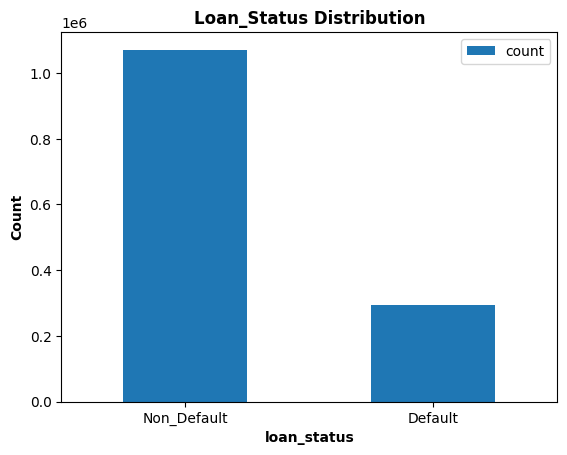

In [ ]:
#Visualizing the class label


dataframe1 = dataset.select('*')
categorical_column = "loan_status"

category_counts = dataframe1.groupBy(categorical_column).count().orderBy(col("count"), ascending=False)
# Convert the Spark DataFrame to Pandas DataFrame
category_counts_pd = category_counts.toPandas()

# Plotting  loan_status distribution
plt.figure(figsize=(10, 2))
category_counts_pd.plot(kind='bar', x='loan_status', y='count', rot=0)
plt.xlabel("loan_status", fontweight='bold')
plt.ylabel("Count", fontweight='bold')
plt.title("Loan_Status Distribution", fontweight='bold')
plt.show();

# **Exploratory Data Analysis: EDA**



In [ ]:
dataset = spark.read.format("csv").option("inferSchema", True).option("header", True).load('/content/drive/MyDrive/MSc/ProjectData/dataframe1-cleaned_060824')
dataframe1 = dataset.select('*')

In [ ]:
dataframe1.show(5) #records: 1365141, feature: 80

+---------+-----------+---------------+----+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+-----------+----------+------------------+------------------+----------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+----------------+--------------+------------+-----------+----------------+-----------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+---

In [ ]:
dataframe2 = dataframe1.select("*")

In [ ]:
# selecting a subset of the feature for EDA

# Select the desired columns
dataframe1 = dataframe1.select('annual_inc', 'loan_status', 'emp_length', 'home_ownership', 'dti', 'sub_grade', 'addr_state')
dataframe1.show(10)

+----------+-----------+----------+--------------+-----+---------+----------+
|annual_inc|loan_status|emp_length|home_ownership|  dti|sub_grade|addr_state|
+----------+-----------+----------+--------------+-----+---------+----------+
|   55000.0|Non_Default|      10.0|      MORTGAGE| 5.91|       C4|        PA|
|   65000.0|Non_Default|      10.0|      MORTGAGE|16.06|       C1|        SD|
|   63000.0|Non_Default|      10.0|      MORTGAGE|10.78|       B4|        IL|
|  104433.0|Non_Default|       3.0|      MORTGAGE|25.37|       F1|        PA|
|   34000.0|Non_Default|       4.0|          RENT| 10.2|       C3|        GA|
|  180000.0|Non_Default|      10.0|      MORTGAGE|14.67|       B2|        MN|
|   85000.0|Non_Default|      10.0|      MORTGAGE|17.61|       B1|        SC|
|   85000.0|Non_Default|       6.0|          RENT|13.07|       A2|        PA|
|   42000.0|Non_Default|      10.0|      MORTGAGE| 34.8|       B5|        RI|
|   64000.0|Non_Default|       3.0|      MORTGAGE|34.95|       C

In [ ]:
#Group by addr_state and loan_status and count occurrences
state_loan_status_counts = dataframe1.groupBy('addr_state', 'loan_status').agg(count('loan_status').alias('count'))

# Show the result
state_loan_status_counts.show()

+----------+-----------+------+
|addr_state|loan_status| count|
+----------+-----------+------+
|        KS|    Default|  2043|
|        WV|    Default|   802|
|        AZ|    Default|  6969|
|        MN|    Default|  5141|
|        MT|Non_Default|  3168|
|        UT|    Default|  1849|
|        NH|    Default|  1052|
|        VA|Non_Default| 30241|
|        WY|Non_Default|  2418|
|        ND|Non_Default|  1273|
|        AL|    Default|  4289|
|        NY|    Default| 26633|
|        UT|Non_Default|  8274|
|        SC|Non_Default| 13319|
|        ME|Non_Default|  1745|
|        AZ|Non_Default| 26150|
|        MO|    Default|  4951|
|        DC|Non_Default|  2984|
|        CA|Non_Default|157055|
|        WA|    Default|  5030|
+----------+-----------+------+
only showing top 20 rows



In [ ]:
#Group by addr_state and loan_status and count occurrences
state_loan_status_counts = dataframe1.groupBy('addr_state', 'loan_status').agg(count('loan_status').alias('count'))

# Show the result
#state_loan_status_counts.show()

# Convert to Pandas DataFrame
state_loan_status_counts_pd = state_loan_status_counts.toPandas()

# Pivot the table for plotting
state_loan_status_pivot = state_loan_status_counts_pd.pivot(index='addr_state', columns='loan_status', values='count')


In [ ]:
!pip install plotly

In [ ]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 27.8 MB/s eta 0:00:00


In [ ]:
import plotly.express as px

# Pivot the DataFrame for plotting
state_loan_pivot = state_loan_status_counts_pd.pivot(index='addr_state', columns='loan_status', values='count').fillna(0)

# Create a choropleth map for default loans
fig_default = px.choropleth(state_loan_pivot,
                           locations=state_loan_pivot.index,
                           locationmode="USA-states",
                           color='Default',
                           scope="usa",
                           title='Loan Default Distribution Across States',
                           color_continuous_scale="Reds"  # Choose a color scale for defaults
                          )
# Display the map
fig_default.show()

In [ ]:
import plotly.express as px

# Pivot the DataFrame for plotting
state_loan_pivot = state_loan_status_counts_pd.pivot(index='addr_state', columns='loan_status', values='count').fillna(0)

# Create a choropleth map for default loans
fig_default = px.choropleth(state_loan_pivot,
                           locations=state_loan_pivot.index,
                           locationmode="USA-states",
                           color='Default',
                           scope="usa",
                           title='<b>Loan Default Distribution Across States</b>', # Bold title
                           color_continuous_scale="Reds",
                           height=600, # Adjust figure height as needed
                           width=800  # Adjust figure width as needed
                          )
# Display the map
fig_default.show()

In [ ]:
!pip install -U kaleido  # Install kaleido using a terminal command

import plotly.express as px
import kaleido  # Import kaleido after installation

# ... (rest of your code)

# Save the Plotly figure as an image file
fig_default.write_image("choropleth_map.png")

#### **EDA 1. Income Exploration with Loan Status**

**To see how income affect loan repayment?**

`To examines whether applicants with lower incomes are more likely to default on loans compared to those with higher incomes. To investigate this, income data will be aggregated into salary bins, and the number of applicants within each bin will be analyzed in relation to their loan status.`

In [ ]:
# Describe the 'annual_inc' column
describe_loan_amnt = dataframe1.select("annual_inc").describe()

# Show the result
describe_loan_amnt.show()

+-------+-----------------+
|summary|       annual_inc|
+-------+-----------------+
|  count|          1365141|
|   mean| 76333.4537386028|
| stddev|70305.87121645629|
|    min|             16.0|
|    max|        1.09992E7|
+-------+-----------------+



In [ ]:
from pyspark.sql.functions import udf

# Salary grouping to visualise against loan_status
# Grouping salary into bins and corresponding labels
bins = [30000, 50000, 70000, 90000, 110000, 130000, 150000]
labels = ['30-50k', '50-70k', '70-90k', '90-110k', '110-130k', '130-150k']

# Function to categorize income
def categorize_income(annual_inc):
    if annual_inc < bins[0]:
        return 'Below 30k'
    for i in range(len(bins) - 1):
        if bins[i] <= annual_inc < bins[i + 1]:
            return labels[i]
    return 'Above 150k'


# Register the function as a UDF
categorize_income_udf = udf(categorize_income)

# Apply the UDF to create a new column 'binned'
dataframe1 = dataframe1.withColumn('binned', categorize_income_udf(col('annual_inc')))

# Group by the 'binned' and 'loan_status' columns and count the occurrences
#analyse_income = dataframe1.groupBy('binned', 'loan_status').agg(count('loan_status').alias('count')).orderBy('binned', 'loan_status')
analyse_income = dataframe1.groupBy('binned', 'loan_status').agg(count('loan_status').alias('count')).orderBy('binned')

# Show the result
analyse_income.show()

+----------+-----------+------+
|    binned|loan_status| count|
+----------+-----------+------+
|  110-130k|    Default| 15681|
|  110-130k|Non_Default| 70675|
|  130-150k|Non_Default| 35684|
|  130-150k|    Default|  7375|
|    30-50k|    Default| 75671|
|    30-50k|Non_Default|237139|
|    50-70k|    Default| 79067|
|    50-70k|Non_Default|274095|
|    70-90k|Non_Default|200846|
|    70-90k|    Default| 52390|
|   90-110k|    Default| 28459|
|   90-110k|Non_Default|123051|
|Above 150k|Non_Default| 71425|
|Above 150k|    Default| 14320|
| Below 30k|    Default| 20722|
| Below 30k|Non_Default| 58541|
+----------+-----------+------+



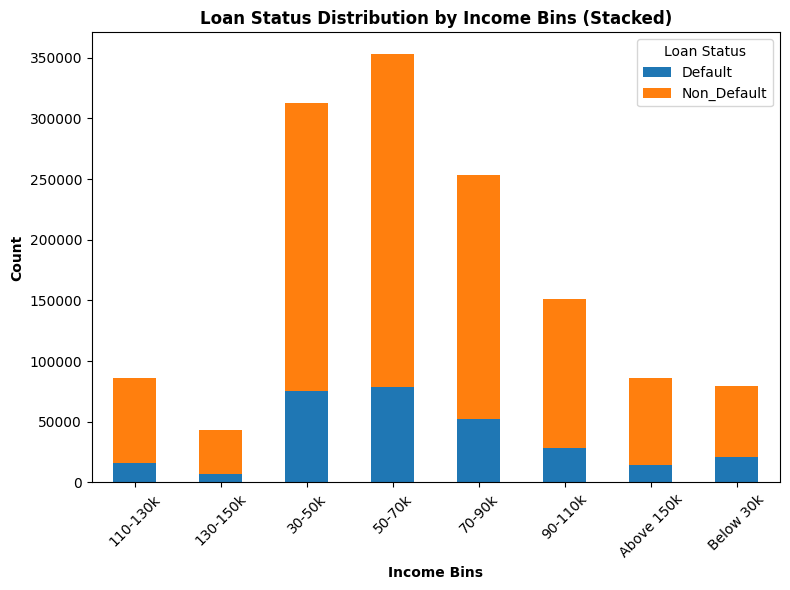

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect the result to a Pandas DataFrame
analyse_income_pd = analyse_income.toPandas()

# Pivot the data for stack plot
analyse_income_pivot = analyse_income_pd.pivot(index='binned', columns='loan_status', values='count').fillna(0)

# Plot the stacked bar chart
analyse_income_pivot.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Loan Status Distribution by Income Bins (Stacked)', fontweight = 'bold')
plt.xlabel('Income Bins', fontweight = 'bold')
plt.ylabel('Count', fontweight = 'bold')
plt.legend(title='Loan Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Summary of Findings**

`- Lower income bins such as '30-50k' and '50-70k' have a higher number of applicants compared to higher income bins.`

`In general, higher income bins have fewer applicants who default on their loans compared to lower income bins.`

`For each income bin, the count of non-defaulted loans (0.0 loan status) is higher than the count of defaulted loans (1.0 loan status), suggesting that for the loan issued out by Lending Club between  2010 to 2019, a majority of applicants across all income ranges tend to pay back their loans.`

#### **EDA 2. Employment Length Exploration with Loan Status**

 **To see how employment Length affect the Loan Repayment?**


`To explored how the length of an applicant's employment affects their likelihood of repaying a loan. Specifically, we may hypothesize that individuals who are earlier in their careers may be more likely to default on loans due to the financial challenges associated with the early stages of their professional lives.`


In [ ]:
from pyspark.sql.functions import round as spark_round

# Group by 'emp_length' and 'loan_status' and count the occurrences
analyse_emp_length = dataframe1.groupBy('emp_length', 'loan_status').agg(count('loan_status').alias('count'))

# Calculate the total counts for each employment length
total_counts = analyse_emp_length.groupBy('emp_length').agg(sum('count').alias('total_count'))

# Join the total counts back to the original dataframe
analyse_emp_length = analyse_emp_length.join(total_counts, on='emp_length')

# Calculate the percentage
analyse_emp_length = analyse_emp_length.withColumn('percentage', spark_round((col('count') / col('total_count')) * 100, 2))

# Collect the result to a Pandas DataFrame
analyse_emp_length_pd = analyse_emp_length.select('emp_length', 'loan_status', 'percentage').toPandas()

# Pivot the Pandas DataFrame for better readability
analyse_emp_length_pd = analyse_emp_length_pd.pivot(index='emp_length', columns='loan_status', values='percentage')

# Display the Pandas DataFrame
print(analyse_emp_length_pd)

loan_status  Default  Non_Default
emp_length                       
0.000000       22.39        77.61
1.000000       22.18        77.82
2.000000       21.40        78.60
3.000000       21.59        78.41
4.000000       21.40        78.60
5.000000       21.14        78.86
5.969687       29.02        70.98
6.000000       20.82        79.18
7.000000       20.74        79.26
8.000000       21.17        78.83
9.000000       21.12        78.88
10.000000      20.22        79.78


In [ ]:
import pandas as pd

# Create the DataFrame
data = {
    'loan_status': ['Default', 'Non_Default'],
    '0.000000': [22.39, 77.61],
    '1.000000': [22.18, 77.82],
    '2.000000': [21.40, 78.60],
    '3.000000': [21.59, 78.41],
    '4.000000': [21.40, 78.60],
    '5.000000': [21.14, 78.86],
    '5.969687': [29.02, 70.98],
    '6.000000': [20.82, 79.18],
    '7.000000': [20.74, 79.26],
    '8.000000': [21.17, 78.83],
    '9.000000': [21.12, 78.88],
    '10.000000': [20.22, 79.78]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)
df = df.set_index('loan_status').T  # Set index and transpose

# Filter out the row with emp_length == 5.969687
df_filtered = df[df.index != '5.969687']

print(df_filtered)

loan_status  Default  Non_Default
0.000000       22.39        77.61
1.000000       22.18        77.82
2.000000       21.40        78.60
3.000000       21.59        78.41
4.000000       21.40        78.60
5.000000       21.14        78.86
6.000000       20.82        79.18
7.000000       20.74        79.26
8.000000       21.17        78.83
9.000000       21.12        78.88
10.000000      20.22        79.78


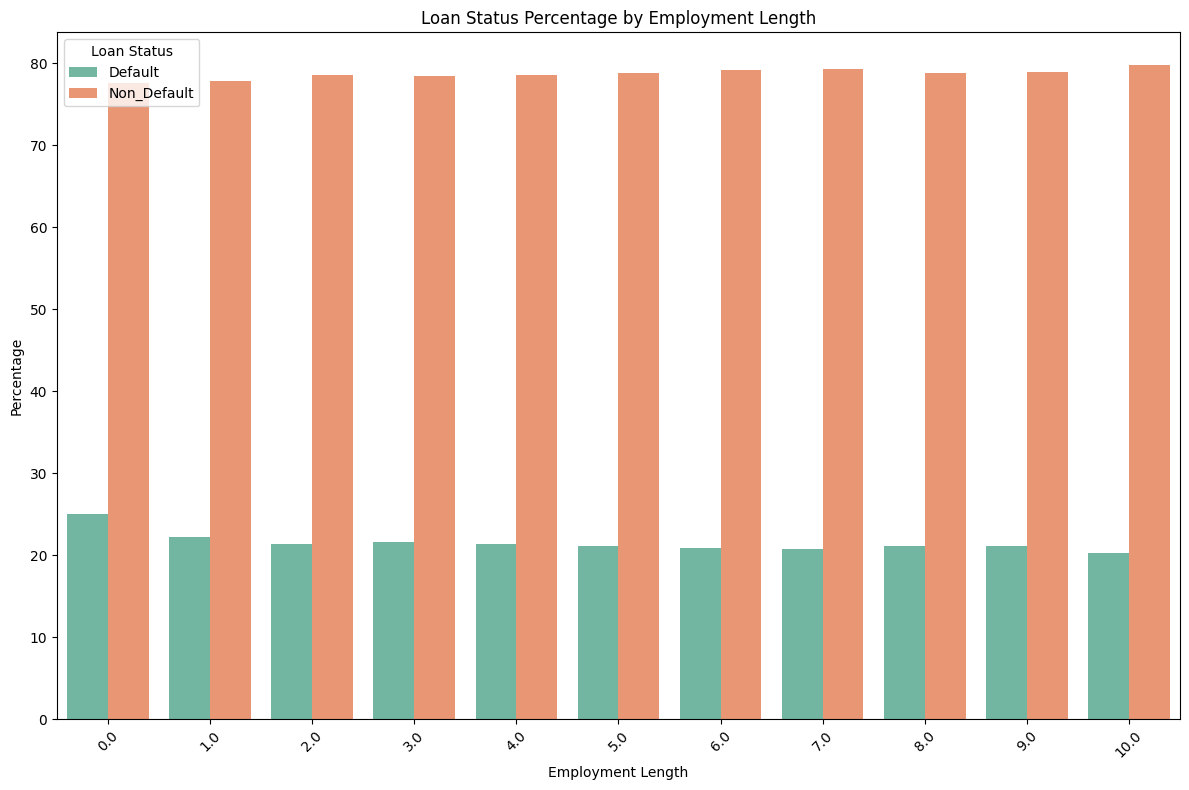

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create the DataFrame
data = {
    'emp_length': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 5.969687, 6.0, 7.0, 8.0, 9.0, 10.0],
    'Default': [25.02, 22.18, 21.40, 21.59, 21.40, 21.14, 29.02, 20.82, 20.74, 21.17, 21.12, 20.22],
    'Non_Default': [77.61, 77.82, 78.60, 78.41, 78.60, 78.86, 70.98, 79.18, 79.26, 78.83, 78.88, 79.78]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Filter out the row with emp_length == 5.969687
df_filtered = df[df['emp_length'] != 5.969687]

# Convert the DataFrame to a format suitable for seaborn
melted_df = df_filtered.melt(id_vars=['emp_length'], value_vars=['Default', 'Non_Default'], var_name='loan_status', value_name='percentage')

# Plotting
plt.figure(figsize=(12, 8))

# Create a grouped bar plot
sns.barplot(data=melted_df, x='emp_length', y='percentage', hue='loan_status', palette='Set2')

plt.title('Loan Status Percentage by Employment Length')
plt.xlabel('Employment Length')
plt.ylabel('Percentage')
plt.legend(title='Loan Status', fontsize=10)  # Adjust font size and legend title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


**Summary of Findings**

`Longer Employment Duration Correlates with Higher Repayment Rates:
The analysis indicates that as the length of employment increases, the percentage of loan repayments increases, and the percentage of defaults decreases. This suggests a positive correlation between employment length and the likelihood of repaying loans.`

`Employment Length as a Factor in Loan Repayment:
While there is a noticeable trend that longer employment duration is associated with higher repayment rates, the differences are relatively modest. Employment length is a contributing factor to loan repayment success, but other factors likely also play significant roles.`

`Implications for Loan Policies:
Financial institutions might consider employment length as one of many factors in loan approval processes, but they should also evaluate other financial and personal metrics to make more comprehensive lending decisions.`

`Final Remarks
This analysis provides insight into the relationship between employment length and loan repayment success. It demonstrates that employment length has a moderate effect on loan repayment outcomes, with longer employment associated with a higher likelihood of repaying loans.`

`Room for future work: To further investigate these findings, additional analyses could explore other variables that might interact with employment length to affect loan repayment, such as income level, credit score, or loan amount.`

#### **EDA 3. Home Ownership Exploration with Loan **Status****

**To explore whether applicants without property ownership have a higher likelihood of defaulting on their loans compared to those with property ownership?**

`Fo0r investigation, we will perform a statistical analysis to assess whether there is a significant difference in the rate of loan charge-offs between property owners and non-owners. This will involve examining loan status outcomes across different home ownership categories and evaluating the strength and significance of the association between 'home_ownership' and 'loan_status'.`




In [ ]:
# "home_ownership" before applying StringIndexer() function
dataframe1.groupBy("home_ownership").count().orderBy('count', ascending = True).show(truncate = False)

+--------------+------+
|home_ownership|count |
+--------------+------+
|NONE          |45    |
|OTHER         |50    |
|ANY           |305   |
|OWN           |147546|
|RENT          |542589|
|MORTGAGE      |674606|
+--------------+------+



In [ ]:
from pyspark.sql.functions import expr

#Categorizing "home_ownership"
# "home_ownership" after applying stingindexer()
#contingency_df = dataframe1.groupBy('home_ownership', 'label').count()
contingency_df = dataframe1.groupBy("home_ownership", 'loan_status').count().orderBy('count', ascending = True).show(truncate = False)

#key: NONE = 5.0, OTHER = 50, ANY = 3.0, OWN = 2.0, RENT = 1.0, MORTGAGE = 0.0

+--------------+-----------+------+
|home_ownership|loan_status|count |
+--------------+-----------+------+
|NONE          |Default    |7     |
|OTHER         |Default    |13    |
|OTHER         |Non_Default|37    |
|NONE          |Non_Default|38    |
|ANY           |Default    |75    |
|ANY           |Non_Default|230   |
|OWN           |Default    |33047 |
|OWN           |Non_Default|114499|
|MORTGAGE      |Default    |125505|
|RENT          |Default    |135038|
|RENT          |Non_Default|407551|
|MORTGAGE      |Non_Default|549101|
+--------------+-----------+------+



In [ ]:
# Aggregate data to create a contingency table
contingency_df = dataframe1.groupBy('home_ownership', 'loan_status').count()

# Pivot the table to create a contingency matrix
contingency_pivot_df = contingency_df.groupBy('home_ownership') \
    .pivot('loan_status') \
    .sum('count') \
    .na.fill(0)  # Fill missing values with 0

In [ ]:
# Rename columns for clarity
contingency_pivot_df = contingency_pivot_df.withColumnRenamed('0', 'Non_Default') \
    .withColumnRenamed('1', 'Default')

In [ ]:
# Add a new column for the total count of each home ownership category
contingency_pivot_df = contingency_pivot_df.withColumn('total', col('Non_Default') + col('Default'))

In [ ]:
# Compute the percentage of each loan status
contingency_pivot_df = contingency_pivot_df.withColumn('Non_Default(%)', (col('Non_Default') / col('total')) * 100) \
                                           .withColumn('Default(%)', (col('Default') / col('total')) * 100)

In [ ]:
# Drop the 'total' column as it's no longer needed
contingency_pivot_df = contingency_pivot_df.drop('total')

# Show the pivoted DataFrame
contingency_pivot_df.show()

# Convert DataFrame to Pandas for better visualization
contingency_pivot_pd = contingency_pivot_df.toPandas()

+--------------+-------+-----------+-----------------+------------------+
|home_ownership|Default|Non_Default|   Non_Default(%)|        Default(%)|
+--------------+-------+-----------+-----------------+------------------+
|           OWN|  33047|     114499|77.60223930164152| 22.39776069835848|
|          RENT| 135038|     407551|75.11228572639695| 24.88771427360304|
|      MORTGAGE| 125505|     549101|81.39580733050106|18.604192669498936|
|           ANY|     75|        230|75.40983606557377| 24.59016393442623|
|         OTHER|     13|         37|             74.0|              26.0|
|          NONE|      7|         38|84.44444444444444|15.555555555555555|
+--------------+-------+-----------+-----------------+------------------+



In [ ]:
# Print the results
print("Home Ownership Analysis Results:")
print(contingency_pivot_pd)

Home Ownership Analysis Results:
  home_ownership  Default  Non_Default  Non_Default(%)  Default(%)
0            OWN    33047       114499       77.602239   22.397761
1           RENT   135038       407551       75.112286   24.887714
2       MORTGAGE   125505       549101       81.395807   18.604193
3            ANY       75          230       75.409836   24.590164
4          OTHER       13           37       74.000000   26.000000
5           NONE        7           38       84.444444   15.555556


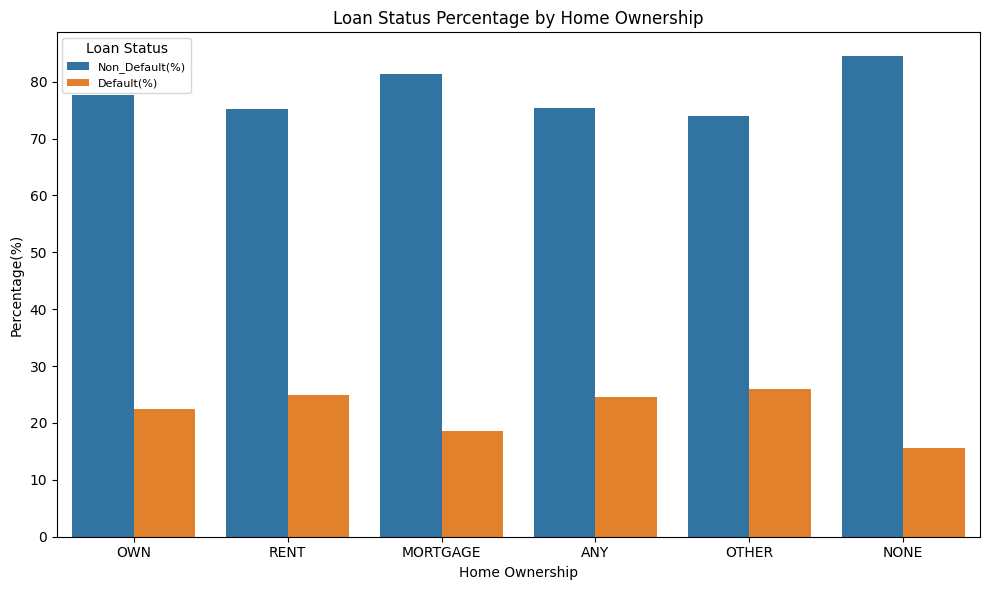

In [ ]:

# Optional: Plot the data using Matplotlib and Seaborn
plt.figure(figsize=(10, 6))

# Melting the DataFrame for a bar plot
contingency_pivot_melted = contingency_pivot_pd.melt(id_vars='home_ownership',
                                                     value_vars=['Non_Default(%)', 'Default(%)'],
                                                     var_name='loan_status',
                                                     value_name='percentage')

# Creating the bar plot
sns.barplot(x='home_ownership', y='percentage', hue='loan_status', data=contingency_pivot_melted)

plt.title('Loan Status Percentage by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Percentage(%)')
plt.legend(title='Loan Status', loc = 'upper left', fontsize = 8,)
plt.tight_layout()
plt.show()

`Conclusion
MORTGAGE holders show the highest likelihood of repaying loans, indicating strong financial stability.
OWN holders also demonstrate a strong ability to repay loans, though slightly less than mortgage holders.
RENT and ANY applicants have similar, slightly lower repayment rates, suggesting higher risk.
OTHER category shows the highest default rate, but the sample size is small, so this result should be interpreted cautiously.
NONE category shows a high repayment rate, but due to the very small sample size, this finding is not robust.`

`These results suggest that home ownership status is a significant factor in predicting loan repayment success, with mortgage holders being the most reliable and renters or other unspecified ownership types being slightly more at risk of default.`

#### **EDA 4. DTI Exploration with Loan Status**

`To explore how an applicant's existing debt (measured by the Debt-to-Income ratio) impact the loan status outcome? Specifically, are applicants with higher DTI ratios more likely to default on loans?`


In [ ]:
# Create bins and labels for DTI
binsdti = [1, 10, 20, 30, 40, 50]
labelsdti = ['1-10', '10-20', '20-30', '30-40', '40-50']

# Define a UDF to categorize DTI
def categorize_dti(dti):
    for i in range(len(binsdti) - 1):
        if binsdti[i] <= dti < binsdti[i + 1]:
            return labelsdti[i]
    return '40-50'

In [ ]:
categorize_dti_udf = udf(categorize_dti, StringType())

# Apply the UDF to create a new column 'binneddti'
loans = dataframe1.withColumn('binneddti', categorize_dti_udf(col('dti')))

# Group by 'binneddti' and 'loan_status' and count occurrences#analyse_dti = loans.groupby('binneddti', 'loan_status').count()

# Group by binneddti and loan_status and count occurrences
analyse_dti = loans.groupBy('binneddti', 'loan_status').agg(count('loan_status').alias('count'))

In [ ]:
# Calculate the percentage of each loan status within each DTI bin
total_counts = analyse_dti.groupBy('binneddti').agg(spark_sum('count').alias('total_count'))
analyse_dti = analyse_dti.join(total_counts, on='binneddti')
analyse_dti = analyse_dti.withColumn('percentage', col('count') * 100 / col('total_count'))

# Pivot the data for better readability
analyse_dti_pivot = analyse_dti.groupBy('binneddti').pivot('loan_status').sum('percentage').orderBy('binneddti', ascending = True).fillna(0)

# Rename columns to Non_Default and Default
analyse_dti_pivot = analyse_dti_pivot.withColumnRenamed('0', 'Non_Default').withColumnRenamed('1', 'Default')

# Show the final DataFrame
analyse_dti_pivot.show()

+---------+------------------+-----------------+
|binneddti|           Default|      Non_Default|
+---------+------------------+-----------------+
|     1-10|16.431178763874748|83.56882123612525|
|    10-20| 19.25060285009245|80.74939714990755|
|    20-30|24.551884297679607| 75.4481157023204|
|    30-40|30.788445526164093| 69.2115544738359|
|    40-50|28.290579551267996|  71.709420448732|
+---------+------------------+-----------------+



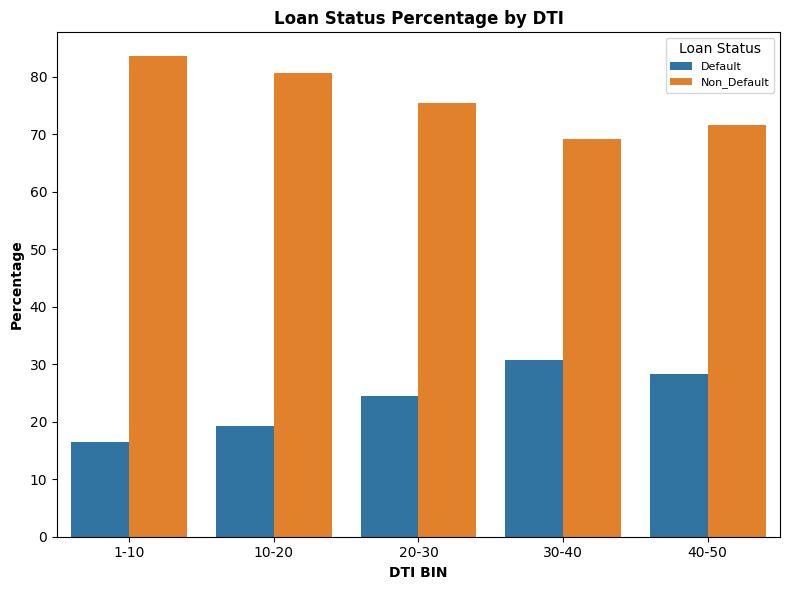

In [ ]:
# Convert to Pandas DataFrame
analyse_dti_pivot_pd = analyse_dti_pivot.toPandas()

# Set the index to binneddti
analyse_dti_pivot_pd.set_index('binneddti', inplace=True)

# Melt the DataFrame for easier plotting
analyse_dti_pivot_melted = analyse_dti_pivot_pd.reset_index().melt(id_vars='binneddti', var_name='loan_status', value_name='percentage')

# Creating the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='binneddti', y='percentage', hue='loan_status', data=analyse_dti_pivot_melted)

plt.title('Loan Status Percentage by DTI', fontweight = 'bold')
plt.xlabel('DTI BIN', fontweight = 'bold')
plt.ylabel('Percentage', fontweight = 'bold')
plt.legend(title='Loan Status', bbox_to_anchor=(1, 1), fontsize = 8)
plt.tight_layout()
plt.show()

`Conclusion:`

`Default Risk Increases with Higher DTI`

`There is a clear trend indicating that as the DTI ratio increases, the percentage of defaults also increases. For instance, the default rate is 16.43% for the 1-10 DTI bin and increases to 30.79% for the 30-40 DTI bin.`

`The percentage of Non_Default loans decreases as the DTI ratio increases. For example, 83.57% of loans are Non_Default for the 1-10 DTI bin, whereas this percentage drops to 69.21% for the 30-40 DTI bin.
This decrease in the non-default rate indicates that lower DTI ratios are associated with a larger proportion of loans that are successfully repaid. Conversely, higher DTI ratios correspond to a higher proportion of defaulted loans.`

#### **EDA 5. Subgrade**

`To explore whether the subgrade assigned to a loan significantly affect its loan status?`

`Specifically, are loans with lower subgrades more likely to default compared to those with higher subgrades?"`


In [ ]:

# Group by subgrade and loan_status and count occurrences
analyse_subgrade = dataframe1.groupBy('sub_grade', 'loan_status').agg(count('loan_status').alias('count'))

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, lit, sum as sum_
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate total counts per subgrade
total_counts = analyse_subgrade.groupBy('sub_grade').agg(sum_('count').alias('total'))

# Join the total counts with the original grouped DataFrame
analyse_subgrade = analyse_subgrade.join(total_counts, on='sub_grade')

# Calculate percentages
analyse_subgrade = analyse_subgrade.withColumn('percentage', (col('count') / col('total')) * 100)

# Pivot table for easier visualization
analyse_subgrade_pivot = analyse_subgrade.groupBy('sub_grade').pivot('loan_status').sum('percentage').fillna(0)

# Rename columns to Non_Default and Default
analyse_subgrade_pivot = analyse_subgrade_pivot.withColumnRenamed('0', 'Non_Default').withColumnRenamed('1', 'Default')

# Convert to Pandas DataFrame
analyse_subgrade_pivot_pd = analyse_subgrade_pivot.toPandas()

# Set the index to subgrade
analyse_subgrade_pivot_pd.set_index('sub_grade', inplace=True)


In [ ]:
# Print the Pandas DataFrame
print(analyse_subgrade_pivot_pd)

             Default  Non_Default
sub_grade                        
D5         35.655645    64.344355
F2         46.452933    53.547067
B4         16.184215    83.815785
A2          5.288320    94.711680
E4         41.788547    58.211453
B2         12.465147    87.534853
C3         24.320293    75.679707
D1         29.639308    70.360692
C4         26.937274    73.062726
F1         43.692368    56.307632
D3         32.693069    67.306931
F5         50.750308    49.249692
G2         50.091743    49.908257
B1         11.512929    88.487071
B3         14.096238    85.903762
E5         44.032344    55.967656
C5         28.184403    71.815597
G3         52.495490    47.504510
A4          7.645032    92.354968
F4         49.184947    50.815053
B5         18.320711    81.679289
E3         40.606157    59.393843
G4         52.941176    47.058824
D2         31.448393    68.551607
C1         20.530939    79.469061
F3         46.382159    53.617841
A5          9.124013    90.875987
E1         37.

In [ ]:
# Group by `sub_grade` and `loan_status` and count occurrences   analyse_subgrade_pivot_pd
analyse_sub_grade = dataframe1.groupBy(['sub_grade', 'loan_status']).count()

In [ ]:
# Calculate the percentage of each `loan_status` category within each `sub_grade`
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as spark_sum


# Calculate the percentage of each `loan_status` category within each `sub_grade`
# Define window specification
window_spec = Window.partitionBy('sub_grade')

# Calculate the total count per `sub_grade`
loans_with_counts = analyse_sub_grade.withColumn('total_count', spark_sum('count').over(window_spec))

# Calculate the percentage
analyse_sub_grade = loans_with_counts.withColumn('percentage', (col('count') / col('total_count')) * 100)

# Pivot the DataFrame to have `loan_status` as columns
analyse_sub_grade_pivot = analyse_sub_grade.groupBy('sub_grade').pivot('loan_status').sum('percentage')

# Show the pivoted DataFrame
analyse_sub_grade_pivot.show()

+---------+------------------+-----------------+
|sub_grade|           Default|      Non_Default|
+---------+------------------+-----------------+
|       A1|3.6386048210372537|96.36139517896275|
|       A2| 5.288319501517471|94.71168049848254|
|       A3| 6.265644349590282|93.73435565040971|
|       A4| 7.645031591039632|92.35496840896037|
|       A5| 9.124013440650153|90.87598655934985|
|       B1|11.512928509665002|  88.487071490335|
|       B2| 12.46514745308311|87.53485254691688|
|       B3|  14.0962380126814|85.90376198731859|
|       B4| 16.18421521891606|83.81578478108393|
|       B5|18.320710992187685|81.67928900781232|
|       C1|20.530938767982292|79.46906123201771|
|       C2|22.350399225143114|77.64960077485689|
|       C3|24.320293078634045|75.67970692136595|
|       C4| 26.93727422003284|73.06272577996717|
|       C5|28.184403100327643|71.81559689967236|
|       D1|29.639307990157743|70.36069200984225|
|       D2|31.448393219451535|68.55160678054847|
|       D3|32.693069

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
analyse_sub_grade_pivot_pd = analyse_sub_grade_pivot.toPandas()

# Print the Pandas DataFrame
#print(analyse_sub_grade_pivot_pd)

# Convert the `loan_status` columns to a more descriptive form
analyse_sub_grade_pivot_pd.rename(columns={'Non_Default': 'Non-Default', 'Default': 'Default'}, inplace=True)

# Melt the DataFrame for a bar plot
analyse_sub_grade_pivot_melted = analyse_sub_grade_pivot_pd.melt(id_vars='sub_grade', value_vars=['Non-Default', 'Default'],
                                                                 var_name='loan_status', value_name='percentage')

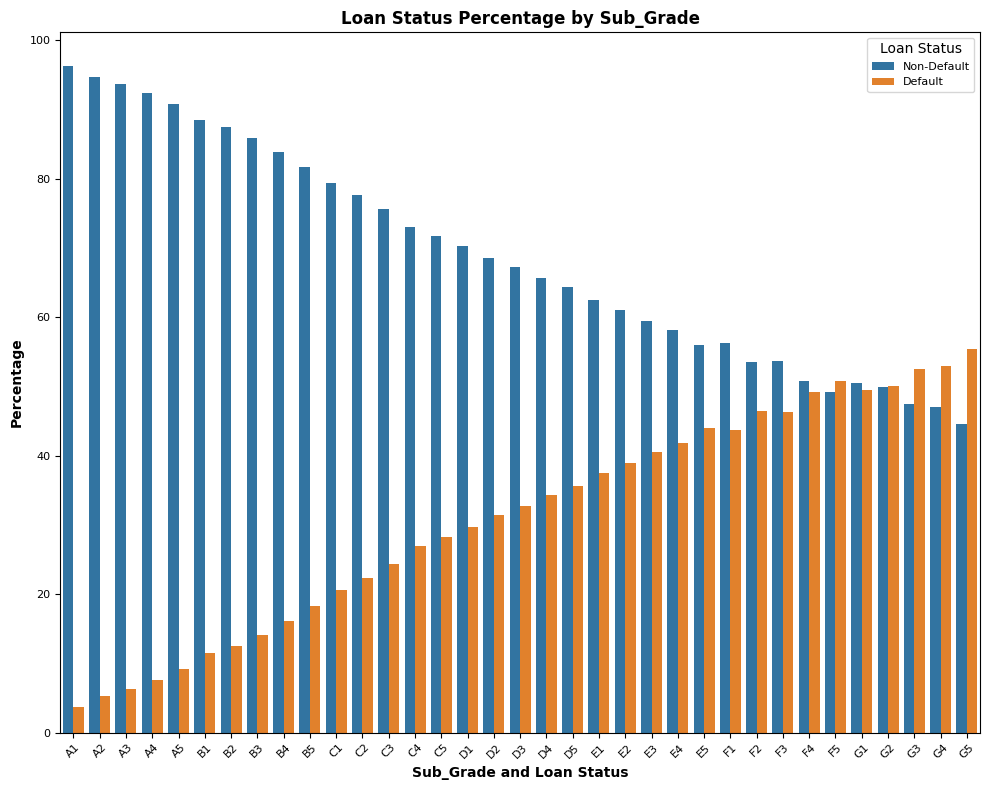

In [ ]:
# Creating the bar plot

plt.figure(figsize=(10, 8))
sns.barplot(x='sub_grade', y='percentage', hue='loan_status', data=analyse_sub_grade_pivot_melted)

plt.title('Loan Status Percentage by Sub_Grade', fontweight = 'bold')
plt.xlabel('Sub_Grade and Loan Status', fontweight = 'bold')
plt.ylabel('Percentage', fontweight = 'bold')
plt.legend(title='Loan Status',  loc='upper right', fontsize = 8)
plt.xticks(rotation=45, fontsize = 8)
plt.yticks(fontsize = 8)
plt.tight_layout()
plt.show()

**Summary of Findings**

`Default Risk Increases with Lower Sub-Grades
There is a clear trend of increasing default risk as you move from higher sub-grades (e.g., A1) to lower sub-grades (e.g., D5). For example, the default rate starts at 3.64% for A1 and increases to 35.66% for D5.`
`This trend indicates that loans classified under lower sub-grades (D1-D5) have a higher likelihood of defaulting compared to those in higher sub-grades (A1-A5). This pattern suggests that as the sub-grade of a loan decreases, the creditworthiness of the borrower may be lower, and thus, the risk of default is higher.`

`Non-Default Percentage with Lower Sub-Grades
The percentage of Non_Default loans decreases as the sub-grade worsens. For instance, 96.36% of loans are Non_Default for A1, whereas 64.34% are Non_Default for D5.`
`This decrease in the non-default percentage indicates that higher sub-grades are associated with a larger proportion of loans that are successfully repaid without default. Conversely, lower sub-grades correspond to a higher proportion of defaulted loans.`


#### **Subplots of loan status distribution by  sub_grade, dti, income and home ownership**

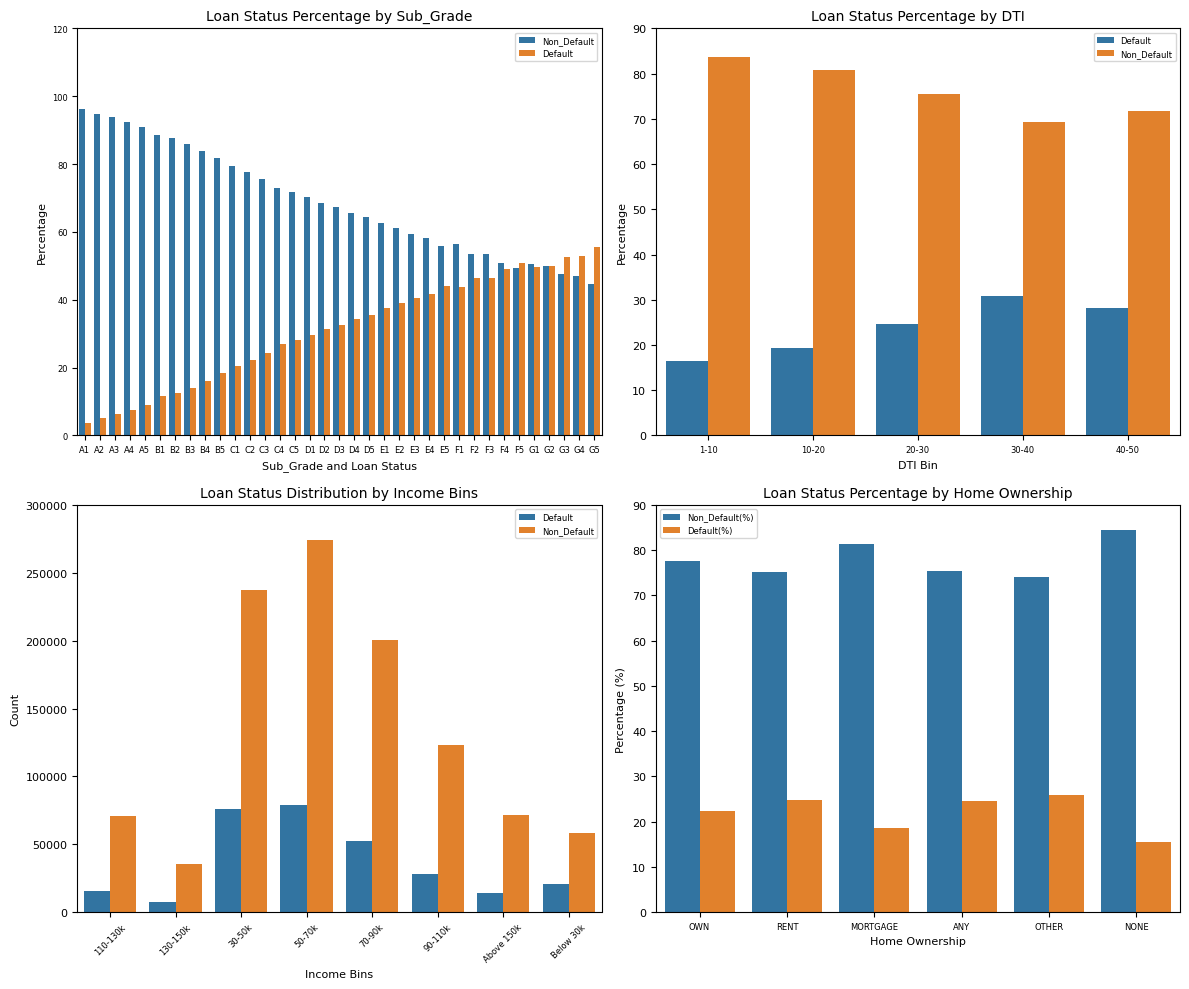

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
analyse_sub_grade_pivot_pd = analyse_sub_grade_pivot.toPandas()

# Melt the DataFrame for a bar plot
analyse_sub_grade_pivot_melted = analyse_sub_grade_pivot_pd.melt(id_vars='sub_grade', value_vars=['Non_Default', 'Default'],
                                                                 var_name='loan_status', value_name='percentage')

# Convert to DataFrame
analyse_sub_grade_pivot_melted = pd.DataFrame(analyse_sub_grade_pivot_melted)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1
sns.barplot(x='sub_grade', y='percentage', hue='loan_status', data=analyse_sub_grade_pivot_melted, ax=axes[0, 0])
axes[0, 0].set_xlabel('Sub_Grade and Loan Status',fontsize=8, fontweight = 'bold')
axes[0, 0].set_ylabel('Percentage', fontsize = 8)
axes[0, 0].set_title('Loan Status Percentage by Sub_Grade', fontsize = 10)
axes[0, 0].legend(fontsize=6)  # Set legend font size to 6

# Get the current x-tick locations and labels
ticks = axes[0, 0].get_xticks()
labels = axes[0, 0].get_xticklabels()

# Set the x-tick locations and labels with the desired font size
axes[0, 0].set_xticks(ticks)
axes[0, 0].set_xticklabels(labels, fontsize=6)

# Get the current y-tick locations
yticks = axes[0, 0].get_yticks()

# Set the y-tick locations and labels with the desired font size
axes[0, 0].set_yticks(yticks) # Set y-ticks locations first
axes[0, 0].set_yticklabels(axes[0, 0].get_yticklabels(), fontsize=6) # Then set font size

axes[0, 0].grid(False)

# Plot 2 (Assuming 'analyse_dti_pivot_melted' is already defined)
analyse_dti_pivot_melted = pd.DataFrame(analyse_dti_pivot_melted)
sns.barplot(x='binneddti', y='percentage', hue='loan_status', data=analyse_dti_pivot_melted, ax=axes[0, 1])
axes[0, 1].set_xlabel('DTI Bin', fontsize=8)
axes[0, 1].set_ylabel('Percentage', fontsize=8)
axes[0, 1].set_title('Loan Status Percentage by DTI', fontsize=10)
axes[0, 1].legend(fontsize=6)  # Set legend font size to 6

# Get the current x-tick locations and labels
ticks = axes[0, 1].get_xticks()
labels = axes[0, 1].get_xticklabels()
# Set the x-tick locations and labels with the desired font size
axes[0, 1].set_xticks(ticks)
axes[0, 1].set_xticklabels(labels, fontsize=6)
# Get the current y-tick locations
yticks = axes[0, 1].get_yticks()
# Set the y-tick locations and labels with the desired font size
axes[0, 1].set_yticks(yticks) # Set y-ticks locations first
axes[0, 1].set_yticklabels(axes[0, 1].get_yticklabels(), fontsize=8) # Then set font size


# Plot 3
sns.barplot(x='binned', y='count', hue='loan_status', data=analyse_income_pd, ax=axes[1, 0])
axes[1, 0].set_xlabel('Income Bins', fontsize=8)
axes[1, 0].set_ylabel('Count', fontsize=8)
axes[1, 0].set_title('Loan Status Distribution by Income Bins', fontsize=10)
axes[1, 0].tick_params(axis='x', labelrotation=45, labelsize=6)  # Rotate x-axis labels
axes[1, 0].legend(fontsize=6)  # Set legend font size to 6


ticks = axes[1, 0].get_xticks()
labels = axes[1, 0].get_xticklabels()
axes[1, 0].set_xticks(ticks)
axes[1, 0].set_xticklabels(labels, fontsize=6)
yticks = axes[1, 0].get_yticks()
axes[1, 0].set_yticks(yticks)
axes[1, 0].set_yticklabels(axes[1, 0].get_yticklabels(), fontsize=8)


# Plot 4
sns.barplot(x='home_ownership', y='percentage', hue='loan_status', data=contingency_pivot_melted, ax=axes[1, 1])
axes[1, 1].set_xlabel('Home Ownership', fontsize=8)
axes[1, 1].set_ylabel('Percentage (%)', fontsize=8)
axes[1, 1].set_title('Loan Status Percentage by Home Ownership', fontsize=10)
axes[1, 1].legend(fontsize=6)  # Set legend font size to 6

ticks = axes[1, 1].get_xticks()
labels = axes[1, 1].get_xticklabels()
axes[1, 1].set_xticks(ticks)
axes[1, 1].set_xticklabels(labels, fontsize=6)
yticks = axes[1, 1].get_yticks()
axes[1, 1].set_yticks(yticks)
axes[1, 1].set_yticklabels(axes[1, 1].get_yticklabels(), fontsize=8)


plt.tight_layout()
plt.show()

In [ ]:
!pip install plotly kaleido

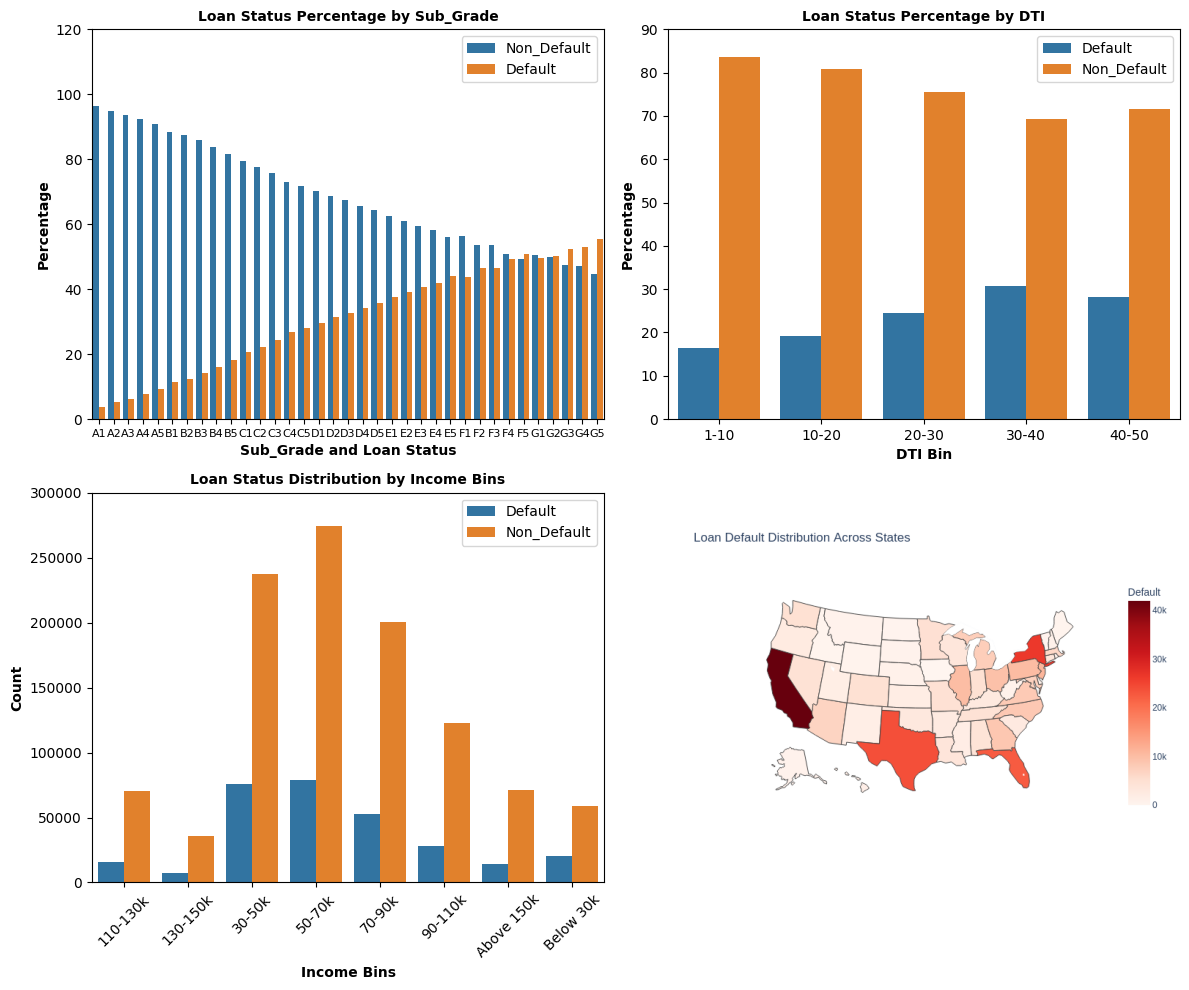

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as mpimg

# Convert Spark DataFrame to Pandas DataFrame for visualization
analyse_sub_grade_pivot_pd = analyse_sub_grade_pivot.toPandas()

# Melt the DataFrame for a bar plot
analyse_sub_grade_pivot_melted = analyse_sub_grade_pivot_pd.melt(id_vars='sub_grade', value_vars=['Non_Default', 'Default'],
                                                                 var_name='loan_status', value_name='percentage')

# Convert to DataFrame
analyse_sub_grade_pivot_melted = pd.DataFrame(analyse_sub_grade_pivot_melted)

# Create the choropleth map for loan defaults
state_loan_pivot = state_loan_status_counts_pd.pivot(index='addr_state', columns='loan_status', values='count').fillna(0)
fig_default = px.choropleth(state_loan_pivot,
                           locations=state_loan_pivot.index,
                           locationmode="USA-states",
                           color='Default',
                           scope="usa",
                           title='Loan Default Distribution Across States',
                           color_continuous_scale="Reds")

# Save the Plotly figure as an image file
fig_default.write_image("choropleth_map.png")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1
sns.barplot(x='sub_grade', y='percentage', hue='loan_status', data=analyse_sub_grade_pivot_melted, ax=axes[0, 0])
axes[0, 0].set_xlabel('Sub_Grade and Loan Status', fontsize=10, fontweight='bold')
axes[0, 0].set_ylabel('Percentage', fontsize=10, fontweight='bold')
axes[0, 0].set_title('Loan Status Percentage by Sub_Grade', fontsize=10, fontweight='bold')
axes[0, 0].legend(fontsize=10)  # Set legend font size to 10

# Set x-ticks and y-ticks font size
ticks = axes[0, 0].get_xticks()
labels = axes[0, 0].get_xticklabels()
axes[0, 0].set_xticks(ticks)
axes[0, 0].set_xticklabels(labels, fontsize=8)
yticks = axes[0, 0].get_yticks()
axes[0, 0].set_yticks(yticks)
axes[0, 0].set_yticklabels(axes[0, 0].get_yticklabels(), fontsize=10)
axes[0, 0].grid(False)

# Plot 2 stacked
analyse_dti_pivot_melted = pd.DataFrame(analyse_dti_pivot_melted)
sns.barplot(x='binneddti', y='percentage', hue='loan_status', data=analyse_dti_pivot_melted, ax=axes[0, 1])
axes[0, 1].set_xlabel('DTI Bin', fontsize=10, fontweight='bold')
axes[0, 1].set_ylabel('Percentage', fontsize=10, fontweight='bold')
axes[0, 1].set_title('Loan Status Percentage by DTI', fontsize=10, fontweight='bold')
axes[0, 1].legend(fontsize=10)  # Set legend font size to 6

# Set x-ticks and y-ticks font size
ticks = axes[0, 1].get_xticks()
labels = axes[0, 1].get_xticklabels()
axes[0, 1].set_xticks(ticks)
axes[0, 1].set_xticklabels(labels, fontsize=10)
yticks = axes[0, 1].get_yticks()
axes[0, 1].set_yticks(yticks)
axes[0, 1].set_yticklabels(axes[0, 1].get_yticklabels(), fontsize=10)

# Plot 3
# analyse_income_pivot.plot(kind='bar', stacked=True, figsize=(8, 6))
sns.barplot(x='binned', y='count', hue='loan_status', data=analyse_income_pd, ax=axes[1, 0])
axes[1, 0].set_xlabel('Income Bins', fontsize=10,fontweight='bold' )
axes[1, 0].set_ylabel('Count', fontsize=10, fontweight='bold')
axes[1, 0].set_title('Loan Status Distribution by Income Bins', fontsize=10, fontweight='bold')
axes[1, 0].tick_params(axis='x', labelrotation=45, labelsize=10)  # Rotate x-axis labels
axes[1, 0].legend(fontsize=10)  # Set legend font size to 6

# Set x-ticks and y-ticks font size
ticks = axes[1, 0].get_xticks()
labels = axes[1, 0].get_xticklabels()
axes[1, 0].set_xticks(ticks)
axes[1, 0].set_xticklabels(labels, fontsize=10)
yticks = axes[1, 0].get_yticks()
axes[1, 0].set_yticks(yticks)
axes[1, 0].set_yticklabels(axes[1, 0].get_yticklabels(), fontsize=10)

# Plot 4: Display the saved Plotly map image
img = mpimg.imread("choropleth_map.png")
axes[1, 1].imshow(img)
axes[1, 1].axis('off')  # Hide axis for the image

# Display Matplotlib plots
plt.tight_layout()
plt.show()


# **Data Cleaning**

**Steps to handle missing values**

**1. Custom logic using UDF (user-defined functions) to fill cat feature with unknown**

**2. Filling features with constant zero due to absence of observation**

**3. Filling other missing values with the average mean**

In [ ]:
# Get the schema of the DataFrame
schema = dataframe1.schema

# Creating list of all numeric variable names
num_feat2 = [field.name for field in schema.fields if isinstance(field.dataType, (IntegerType, LongType, FloatType, DoubleType))]

# Print the names of numeric variables
print("Numeric variables:")
print(num_feat2)

# Print the count of numeric variables
print("Number of numeric variables:", len(num_feat2))

# Find numeric features with null values
num_feat_with_nulls = [col for col in num_feat2 if dataframe1.filter(dataframe1[col].isNull()).count() > 0]

# Print the names of numeric features with null values
print("Numeric variables with null values:")
print(num_feat_with_nulls)

# Print the count of numeric features with null values
print("Number of numeric variables with null values:", len(num_feat_with_nulls))

Numeric variables:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length', 'inq_last_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'issue_year', 'earliest_cr_line_year', 'oldest_credit_line']
Number of numeric variables: 44
Numeric variables with null values:
['emp_length', 'inq_last_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'mo_sin_old_il_a

In [ ]:
# Get the schema of the DataFrame
schema = dataframe1.schema

# Creating list of all categorical variable names
cat_feat2 = [field.name for field in schema.fields if isinstance(field.dataType, StringType)]

# Print the names of categorical variables
print("Categorical variables:")
print(cat_feat2)

# Print the count of categorical variables
print("Number of categorical variables:", len(cat_feat2))

# Find categorical features with null values
cat_feat_with_nulls = [col for col in cat_feat2 if dataframe1.filter(dataframe1[col].isNull()).count() > 0]

# Print the names of categorical features with null values
print("Categorical variables with null values:")
print(cat_feat_with_nulls)

# Print the count of categorical features with null values
print("Number of categorical variables with null values:", len(cat_feat_with_nulls))

Categorical variables:
['grade', 'sub_grade', 'emp_title', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'avg_cur_bal', 'bc_util', 'disbursement_method']
Number of categorical variables: 57
Categorical variables 

In [ ]:
dataframe1.show(5)

+---------+-----------+---------------+----+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+-----------+----------+------------------+--------------------+----------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+----------------+--------------+------------+-----------+----------------+-----------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-

In [ ]:
# save the modified DataFrame to a new CSV file - data fram 2010 - 2019
dataframe1.write.csv('/content/drive/MyDrive/MSc/ProjectData/dataframe1_v1', header=True, mode='overwrite')

In [ ]:
# Calculate the total count of missing values for each column
missing_values_count = dataframe1.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in dataframe1.columns])

missing_values_count.show()

+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-----------+----------+-------+-----+----------+---+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+----------------+--------------+------------+-----------+----------------+-----------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----

In [ ]:
#1.  Logical filling of cat features with UDF

def custom_fill(value):
    if value is None:
        return "unknown"
    else:
        return value

custom_fill_udf = F.udf(custom_fill, StringType())

columns_to_fill = ['emp_title', 'title']


# df_filled = dataframe1

for column in columns_to_fill:
    dataframe1 = dataframe1.withColumn(column, custom_fill_udf(F.col(column)))

#dataframe1.show(5)

In [ ]:
#2. fill zero for non observation values for missing variables (runs for 12 mins)

# dealing with null values with CAT FEATURES (DUE TO absence observation:)
#missing values here likely mean absence of the feature for the borrower.
# 'inq_last_6mths' may mean no record history found or open at the time of this enquiry
# is unknown we choose to fill zero here rather than the mean
# 'tot_coll_amt' is not applicable for those that make their payments, so we fill zero rather than the mean

fillzero = ['inq_last_6mths','tot_coll_amt']
# Fill zero values for specified columns
for col_name in fillzero:
    dataframe1 = dataframe1.na.fill({col_name: 0})

In [ ]:
#3. fillmean values for missing variables (runs for 12 mins)

fillmean = ['emp_length','revol_util','tot_cur_bal','total_rev_hi_lim','total_cu_tl','acc_open_past_24mths','avg_cur_bal',
'bc_open_to_buy','bc_util','mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc','mths_since_recent_bc',
'mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts',
'num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','percent_bc_gt_75',
'tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit']

# Fill mean values for specified columns last_credit_pull_year` last_pymnt_month
for col_name in fillmean:
    mean_value = dataframe1.select(avg(col_name)).collect()[0][0]
    dataframe1 = dataframe1.na.fill({col_name: mean_value})

In [ ]:
# checking to see all missing values finally handled

missing_values = dataframe1.select([sum(col(c).isNull().cast("int")).alias(c) for c in dataframe1.columns])
missing_values.show()

+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-----------+----------+-------+-----+----------+---+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+----------------+--------------+------------+-----------+----------------+-----------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----

In [ ]:
print(len(dataframe1.columns))

dataframe1.count()

91


1365141

In [ ]:
# save the modified DataFrame uptofilling missing data in a new CSV file - data fram 2010 - 2019
dataframe1.write.csv('/content/drive/MyDrive/MSc/ProjectData/dataframe1-cleaned_060824', header=True, mode='overwrite')

In [ ]:
dataset = spark.read.format("csv").option("inferSchema", True).option("header", True).load('/content/drive/MyDrive/MSc/ProjectData/dataframe1-cleaned_060824')


In [ ]:
dataset = spark.read.format("csv").option("inferSchema", True).option("header", True).load('/content/drive/MyDrive/MSc/ProjectData/dataframe1-cleaned_060824')

In [ ]:
#copy os dataframe1
dataframe1 = dataset.select('*')

In [ ]:
dataset.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: integer (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: double (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- fico_range_low: double (nullable = true)
 |-- fico_range_high: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- open_acc: double (n

#### **StringIndexer for cat features**

for label features and cat features

In [ ]:
dataset.show(5)

+---------+-----------+---------------+----+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+-----------+----------+------------------+------------------+----------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+----------------+--------------+------------+-----------+----------------+-----------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+---

In [ ]:
# indexing cat features
# grade|sub_grade|emp_title|home_ownership,verification_status|loan_status|pymnt_plan|purpose|title|addr_state, initial_list_status, application_type, hardship_flag,
# disbursement_method|debt_settlement_flag|issue_month|earliest_cr_line_month|issue_year, earliest_cr_line_year|

columns_to_index =  ['grade', 'sub_grade', 'emp_title', 'home_ownership','verification_status', 'pymnt_plan', 'purpose', 'title', 'addr_state','initial_list_status',
                    'application_type','hardship_flag', 'disbursement_method','debt_settlement_flag','issue_month','earliest_cr_line_month','issue_year','earliest_cr_line_year']

for column in columns_to_index:
  indexer = StringIndexer(inputCol = column, outputCol = column + '_indexed')
  dataset = indexer.fit(dataset).transform(dataset)

In [ ]:
dataset.show(5)

+---------+-----------+---------------+----+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+-----------+----------+------------------+------------------+----------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+----------------+--------------+------------+-----------+----------------+-----------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+---

**Label encoding**

In [ ]:
from pyspark.sql.functions import when, col

# # Define the new column with encoded values
# dataset = dataset.withColumn(
#     "loan_status_indexed",
#     when(col("loan_status") == "Default", 0.0).otherwise(1.0)
# )

In [ ]:
dataset = dataset.drop('grade', 'sub_grade', 'emp_title', 'home_ownership','verification_status', 'pymnt_plan', 'purpose', 'title', 'addr_state','initial_list_status',
                    'application_type','hardship_flag', 'disbursement_method','loan_status','debt_settlement_flag', 'issue_month','earliest_cr_line_month', 'issue_year','earliest_cr_line_year')


In [ ]:
#Renaming features to their original for simplicity
#'grade', 'sub_grade', 'emp_title', 'home_ownership','verification_status', 'pymnt_plan', 'purpose', 'title', 'addr_state','initial_list_status',
#'application_type','hardship_flag', 'disbursement_method','loan_status','debt_settlement_flag',
#'issue_month','earliest_cr_line_month'
 # 'issue_year','earliest_cr_line_year'

dataset = dataset.withColumnRenamed("grade_indexed","grade") \
                        .withColumnRenamed("sub_grade_indexed","sub_grade") \
                        .withColumnRenamed("emp_title_indexed","emp_title") \
                        .withColumnRenamed("home_ownership_indexed","home_ownership")\
                        .withColumnRenamed("pymnt_plan_indexed","pymnt_plan")\
                        .withColumnRenamed("verification_status_indexed","verification_status")\
                        .withColumnRenamed("purpose_indexed","purpose")\
                        .withColumnRenamed("title_indexed","title")\
                        .withColumnRenamed("addr_state_indexed","addr_state")\
                        .withColumnRenamed("initial_list_status_indexed","initial_list_status")\
                        .withColumnRenamed("application_type_indexed","application_type")\
                        .withColumnRenamed("disbursement_method_indexed","disbursement_method") \
                        .withColumnRenamed("debt_settlement_flag_indexed","debt_settlement_flag")\
                        .withColumnRenamed("hardship_flag_indexed","hardship_flag")\
                        .withColumnRenamed("issue_month_indexed","issue_month")\
                        .withColumnRenamed("earliest_cr_line_month_indexed","earliest_cr_line_month")\
                        .withColumnRenamed("earliest_cr_line_year_indexed","earliest_cr_line_year")\
                        .withColumnRenamed("issue_year_indexed","issue_year")\
                        .withColumnRenamed("loan_status_indexed","label")

#dataset.show(5)

In [ ]:
from pyspark.sql import functions as F

# List of columns to round
columns_to_round = ['emp_length', 'total_pymnt', 'bc_open_to_buy','bc_util', 'mths_since_recent_bc', 'mths_since_recent_inq',
                    'num_tl_120dpd_2m', 'percent_bc_gt_75', ]

# Round the specified columns to 3 decimal places
for col in columns_to_round:
    dataset = dataset.withColumn(col, F.round(F.col(col), 3))

# Show the updated DataFrame
#dataset.show()

In [ ]:
dataset.show(5)

+---------+-----------+---------------+----+--------+-----------+----------+----------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+--------------+------------+-----------+----------------+-----------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----------------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-

In [ ]:
print(len(dataset.columns))

91


In [ ]:
dataset.count()

1365141

In [ ]:
# Type casting all data types to double for consistency during modeling

for c in dataset.columns:
    dataset = dataset.withColumn(c, F.col(c).cast("double"))

# Show the updated DataFrame
#dataset.printSchema()

In [ ]:
# save the modified DataFrame upto EDA in a new CSV file - data fram 2010 - 2019
dataset.write.csv('/content/drive/MyDrive/MSc/ProjectData/dataframe1-stringIndexedDouble_060824', header=True, mode='overwrite')

# **Feature Selection:**

`Base on the differences between classes label average mean and standard deviation:`

`To compare the average mean and standard deviation of both classe label to evaluate feature stability or variability.`

`Feature are selected here base on the analysis of the binary class label average means and standard deviations. Features that exhibit a significant difference in their mean or standard deviation between the two classes are considered to be good candidates for linear separability. This indicates that such features can effectively differentiate between the classes.`

#### To assess the linear separability of the features

In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, stddev, col

# Checking for linear separability between features- to see if features are correlated or not

df = dataset.select('*')

# List of numeric column names (excluding the 'label' column)
numeric_columns = [col_name for col_name in df.columns if col_name != 'label']

# Iterate over numeric columns
for col_name in numeric_columns:
    # Calculate average and standard deviation for class 0
    class_0_stats = df.filter(df['label'] == 0.0).select(avg(col(col_name)).alias(f"avg_{col_name}_0"),
                                                         stddev(col(col_name)).alias(f"stddev_{col_name}_0")).first()

    # Calculate average and standard deviation for class 1
    class_1_stats = df.filter(df['label'] == 1.0).select(avg(col(col_name)).alias(f"avg_{col_name}_1"),
                                                         stddev(col(col_name)).alias(f"stddev_{col_name}_1")).first()

    # Print statistics for class 0
    print(f"Class 0 distribution for column {col_name}: ")
    print("AVG ", col_name, ": ", class_0_stats[f"avg_{col_name}_0"])
    print("STD ", col_name, ": ", class_0_stats[f"stddev_{col_name}_0"])

    # Print statistics for class 1
    print(f"Class 1 distribution for column {col_name}: ")
    print("AVG ", col_name, ": ", class_1_stats[f"avg_{col_name}_1"])
    print("STD ", col_name, ": ", class_1_stats[f"stddev_{col_name}_1"])
    print()

Class 0 distribution for column loan_amnt: 
AVG  loan_amnt :  14155.264425230715
STD  loan_amnt :  8673.854074492285
Class 1 distribution for column loan_amnt: 
AVG  loan_amnt :  15700.602686551918
STD  loan_amnt :  8908.641367653623

Class 0 distribution for column funded_amnt: 
AVG  funded_amnt :  14147.382533673805
STD  funded_amnt :  8669.511644668024
Class 1 distribution for column funded_amnt: 
AVG  funded_amnt :  15694.02420961234
STD  funded_amnt :  8905.027549246397

Class 0 distribution for column funded_amnt_inv: 
AVG  funded_amnt_inv :  14136.917966731577
STD  funded_amnt_inv :  8665.151696497956
Class 1 distribution for column funded_amnt_inv: 
AVG  funded_amnt_inv :  15681.203785284126
STD  funded_amnt_inv :  8900.798622474058

Class 0 distribution for column term: 
AVG  term :  40.91297822775737
STD  term :  9.683708479715543
Class 1 distribution for column term: 
AVG  term :  45.4943357679146
STD  term :  11.735506623110016

Class 0 distribution for column int_rate: 
AV

#### Corelation analysis with Heatmap

due to the large number of features, I checked for correlations between the features as such correlations will make model explainability difficult and also cause data leakage.

In [ ]:
dataset = spark.read.format("csv").option("inferSchema", True).option("header", True).load('/content/drive/MyDrive/MSc/ProjectData/dataframe1-stringIndexedDouble_070824')
#dataset.printSchema()

In [ ]:
# Rf important features
dataframe1 = dataset.select('loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
                            'fico_range_high', 'revol_bal', 'total_pymnt', 'total_rec_prncp', 'total_rec_int',
                            'last_pymnt_amnt', 'last_fico_range_low', 'tot_cur_bal', 'total_rev_hi_lim',
                            'total_cu_tl', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_tl_op_past_12m',
                            'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'sub_grade',
                            'verification_status', 'title', 'initial_list_status', 'issue_month', 'Label')

In [ ]:
dataframe1.show(5)

+---------+-----------+--------+-----------+----------+-----+---------------+---------+-----------+---------------+-------------+---------------+-------------------+-----------+----------------+-----------+--------------+-------+--------+------------------+---------------+-----------------+--------------+---------+-------------------+-------+-------------------+-----------+-----+
|loan_amnt|funded_amnt|int_rate|installment|annual_inc|  dti|fico_range_high|revol_bal|total_pymnt|total_rec_prncp|total_rec_int|last_pymnt_amnt|last_fico_range_low|tot_cur_bal|total_rev_hi_lim|total_cu_tl|bc_open_to_buy|bc_util|mort_acc|num_tl_op_past_12m|tot_hi_cred_lim|total_bal_ex_mort|total_bc_limit|sub_grade|verification_status|  title|initial_list_status|issue_month|Label|
+---------+-----------+--------+-----------+----------+-----+---------------+---------+-----------+---------------+-------------+---------------+-------------------+-----------+----------------+-----------+--------------+-------+-----

In [ ]:
# Import necessary libraries
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# corr of the important RF features
features = ['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
            'fico_range_high', 'revol_bal', 'total_pymnt', 'total_rec_prncp', 'total_rec_int',
            'last_pymnt_amnt', 'last_fico_range_low', 'tot_cur_bal', 'total_rev_hi_lim',
            'total_cu_tl', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_tl_op_past_12m',
            'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'sub_grade',
            'verification_status', 'title', 'initial_list_status', 'issue_month', 'Label']

# Assemble the features into a feature vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_vector = assembler.transform(dataframe1).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

# Convert the matrix into a pandas DataFrame for visualization
corr_df = pd.DataFrame(correlation_matrix, index=features, columns=features)

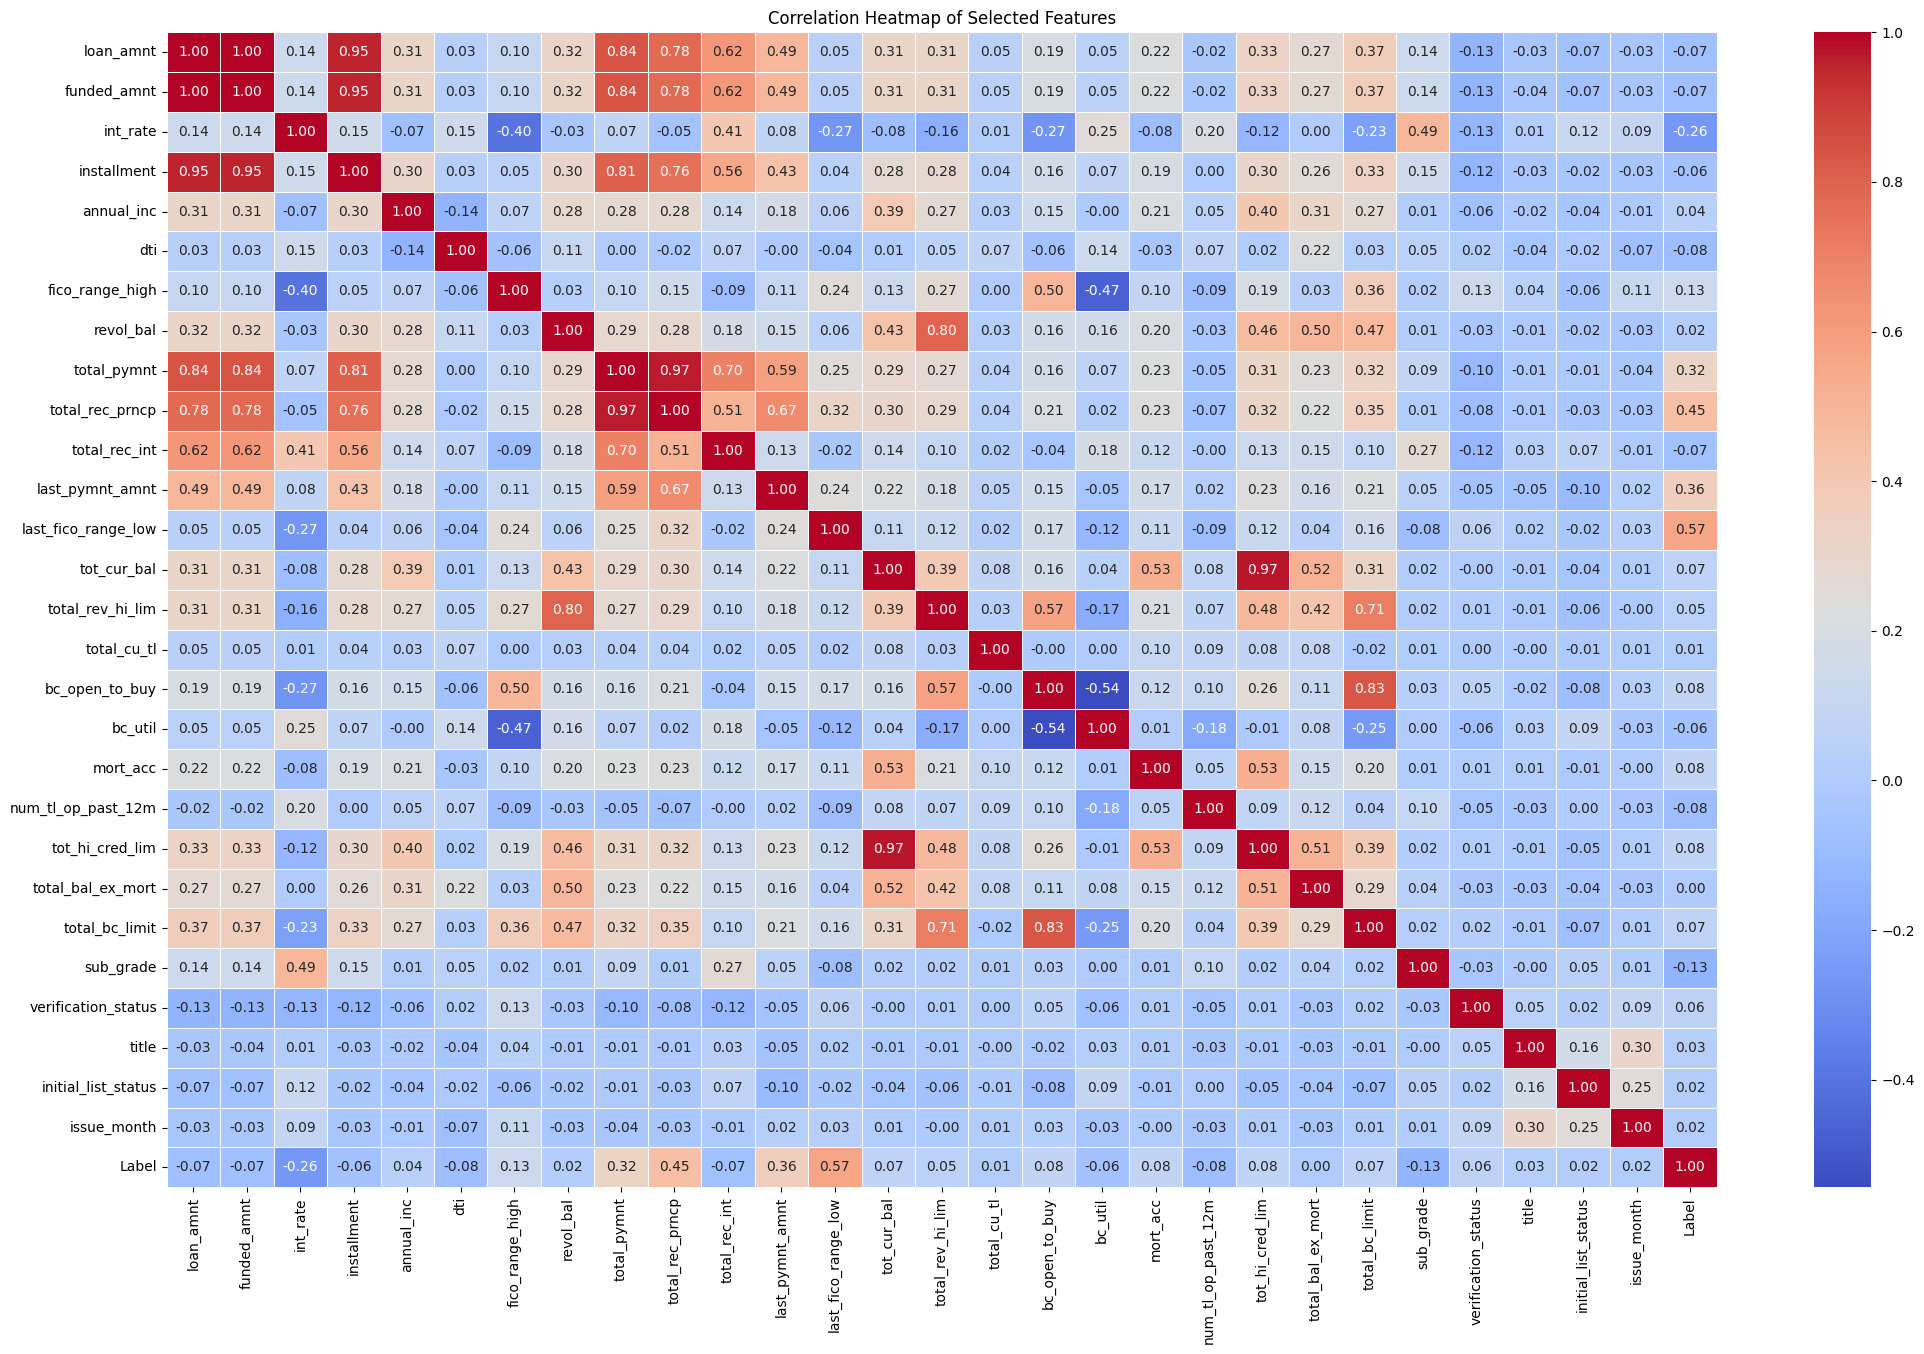

In [ ]:
# Plot the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features")
plt.show()

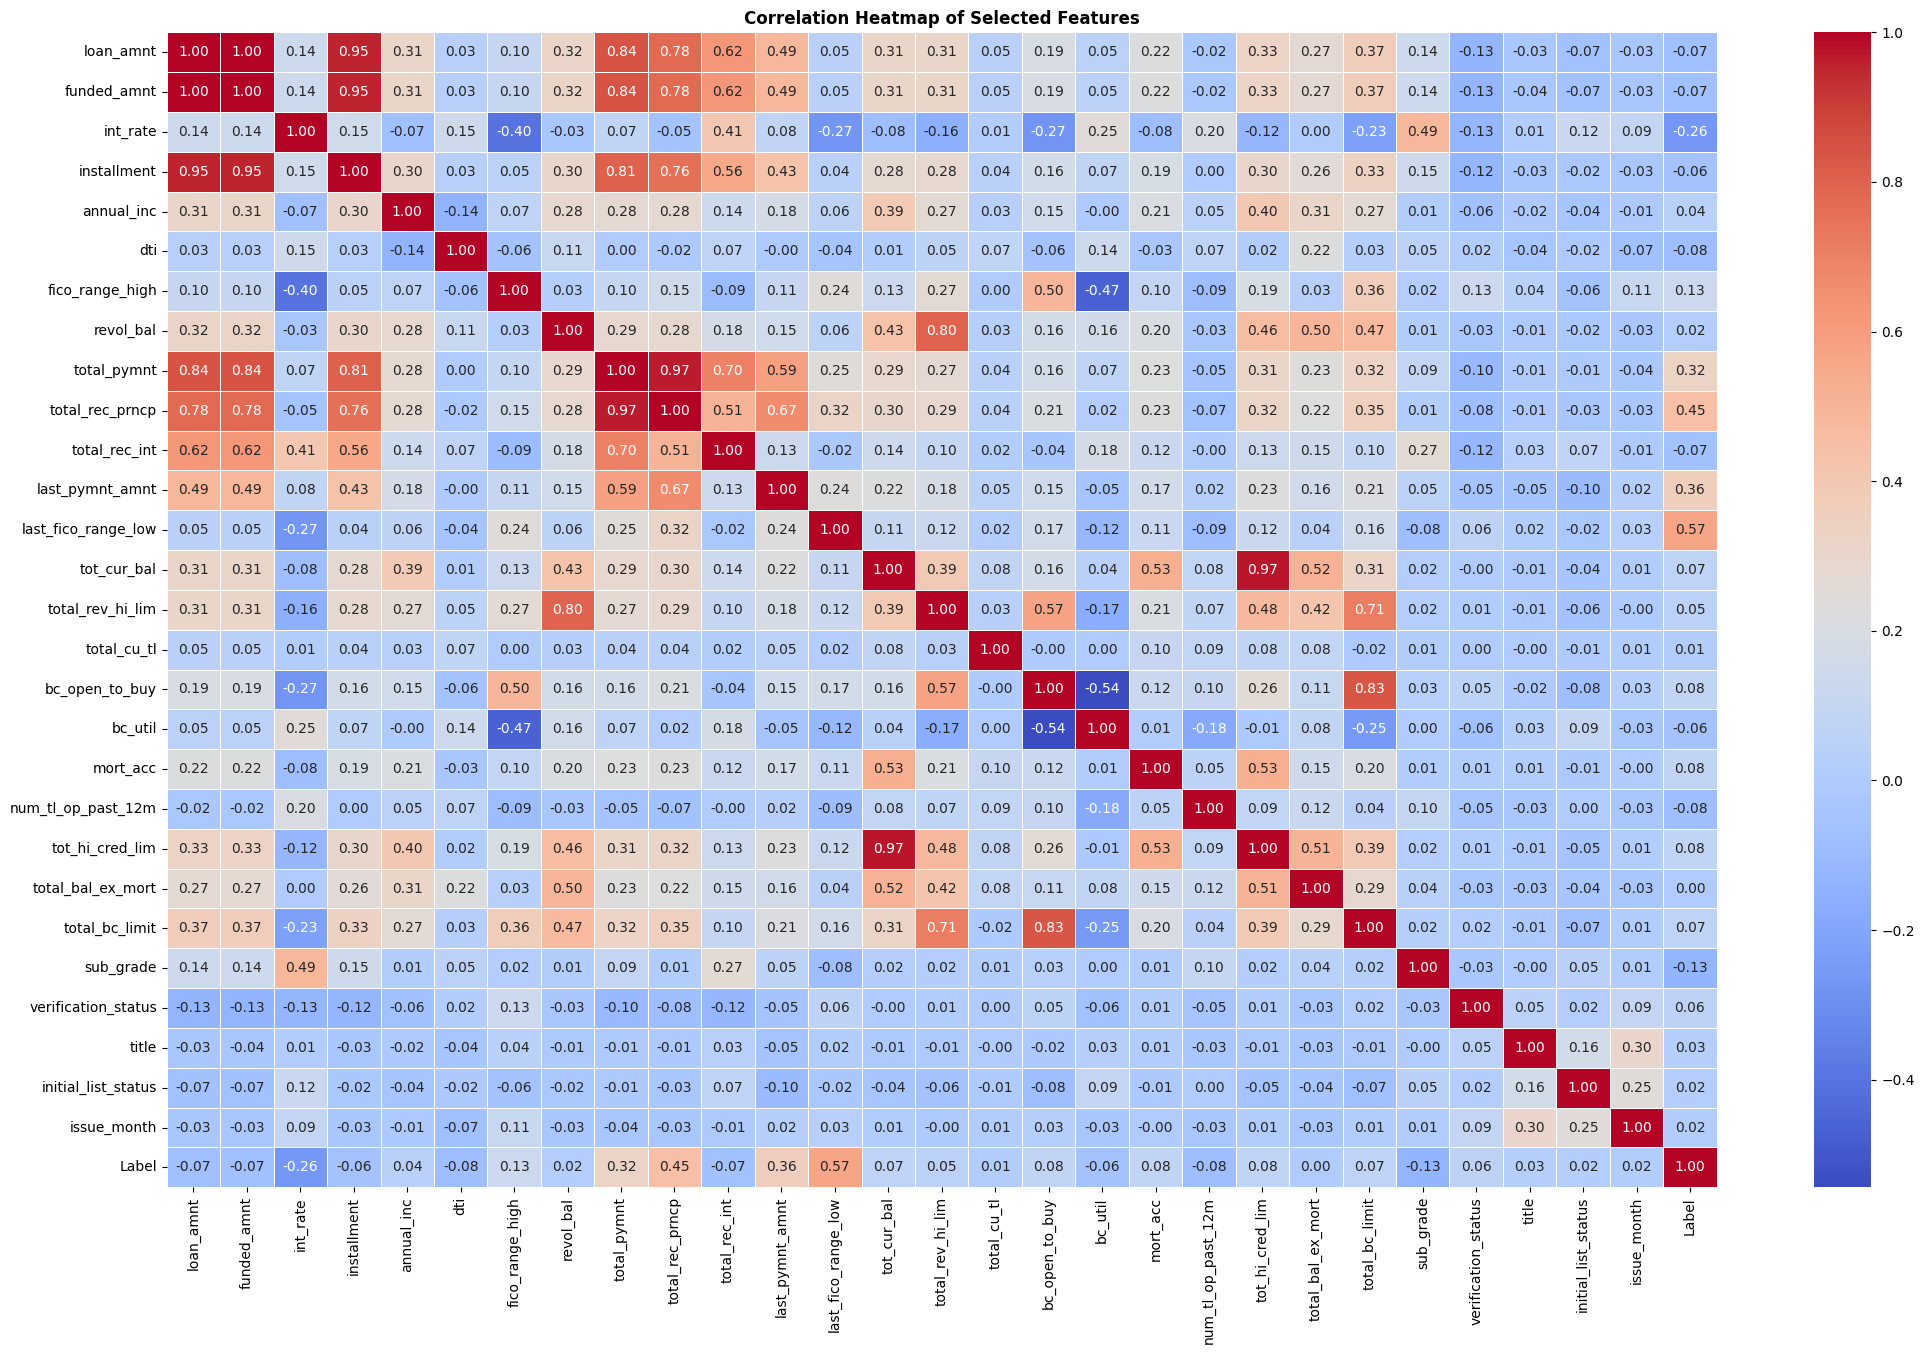

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features", fontweight='bold') # Make title bold
plt.show()

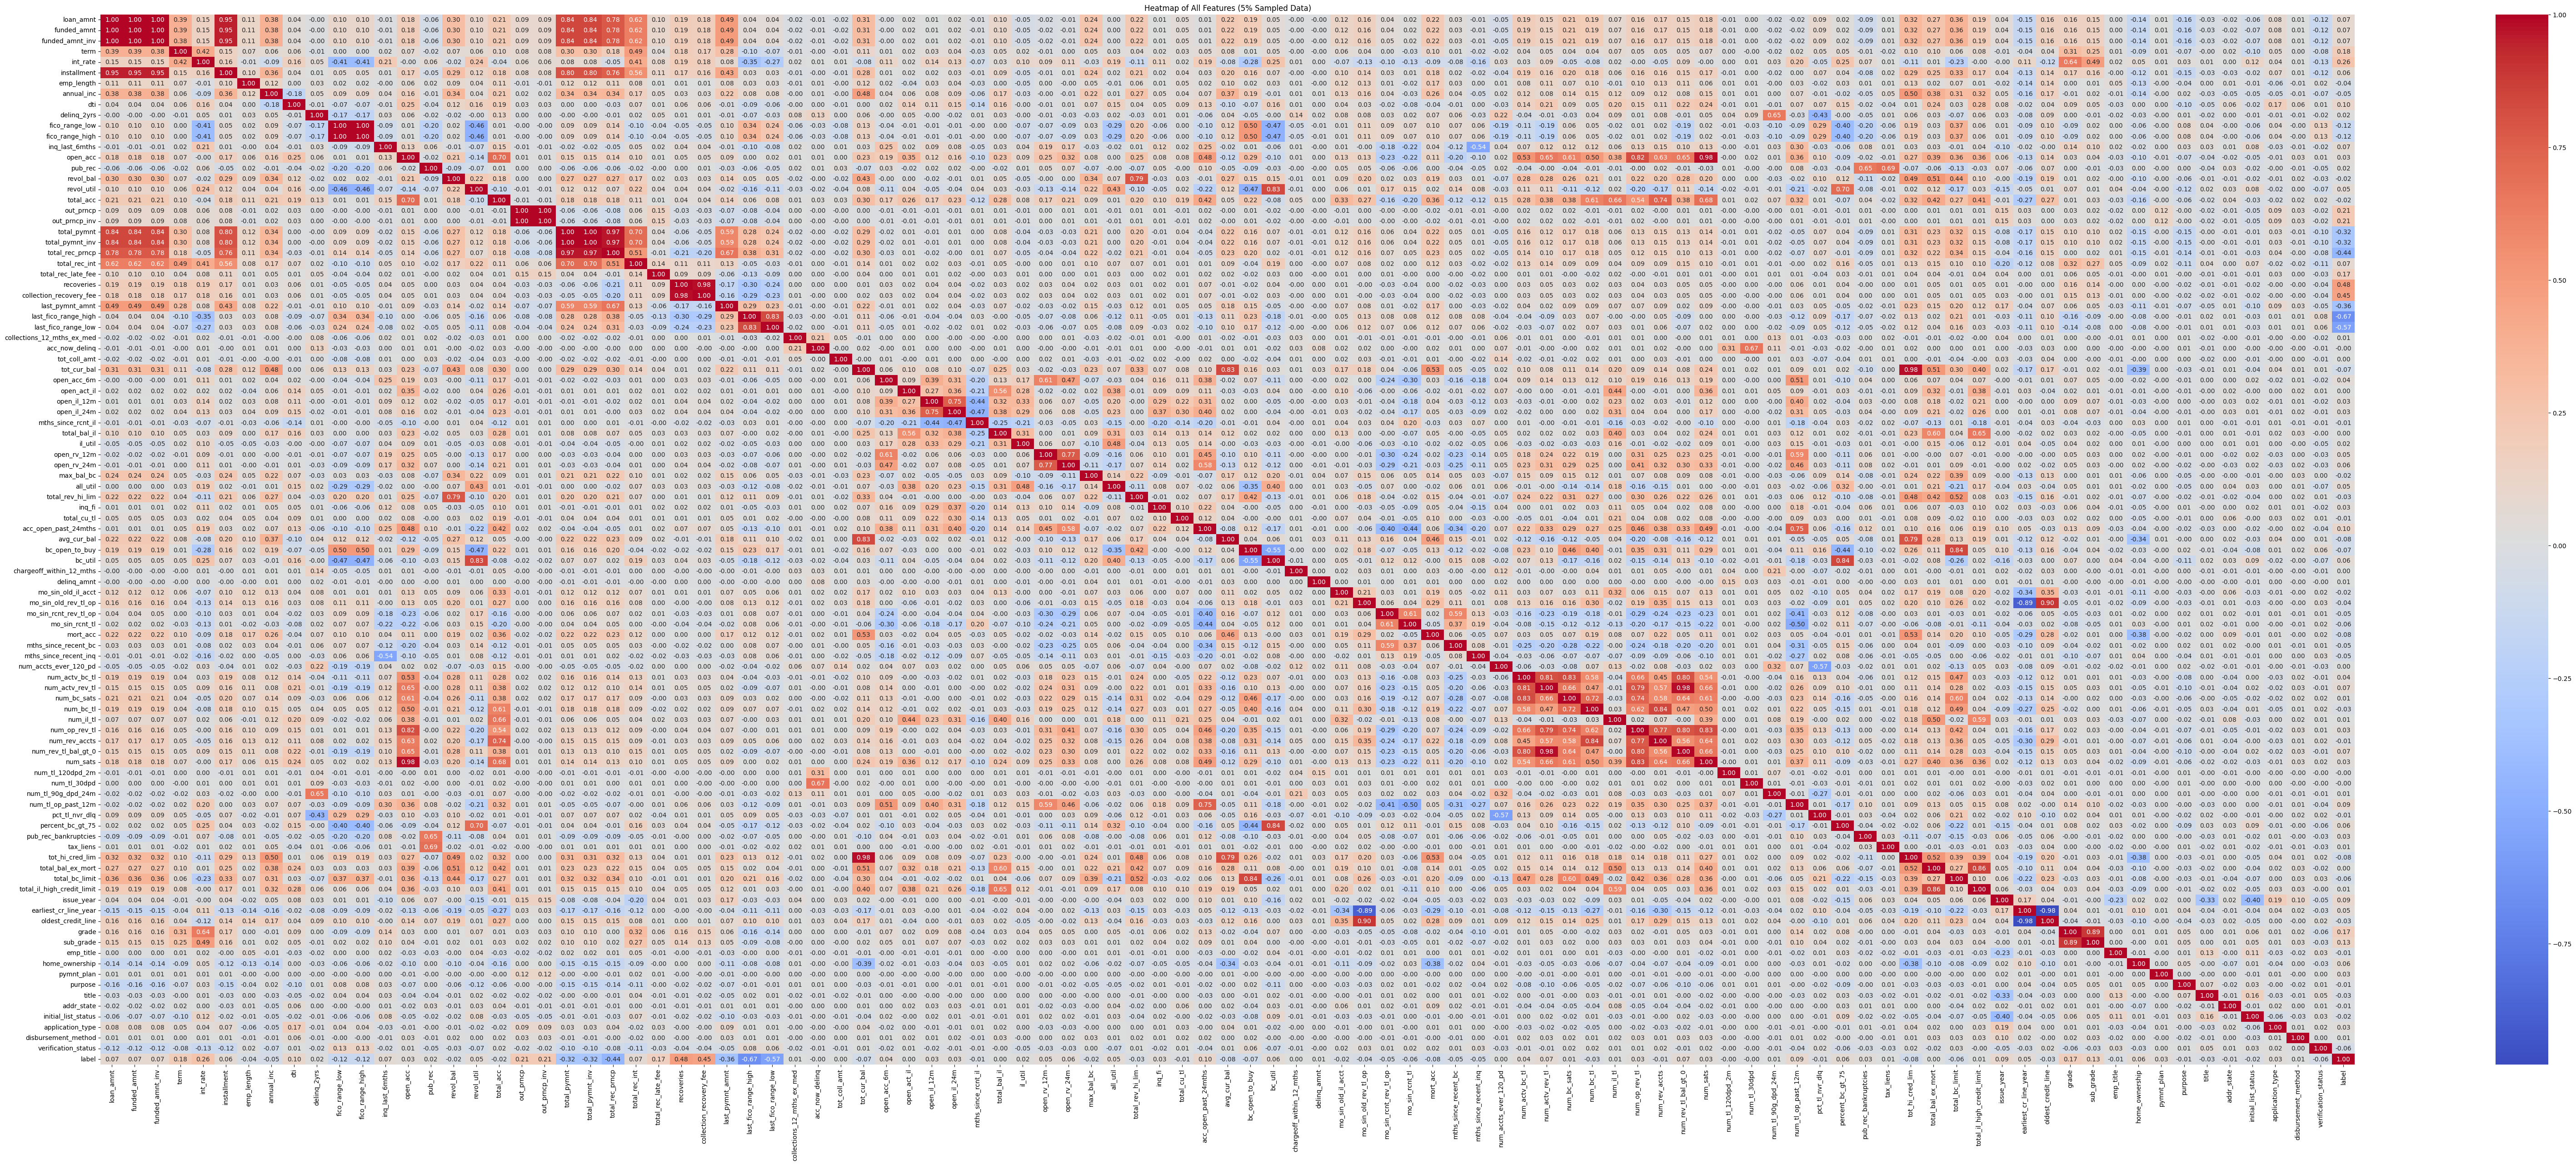

In [ ]:
# Sample 5% of all 91 features
sampled_df = dataset.sample(fraction=0.05).toPandas()

# Compute the correlation matrix
corr = sampled_df.corr()

# Generate a heatmap
plt.figure(figsize=(80, 60))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Heatmap of All Features (5% Sampled Data)')
plt.show()

In [ ]:
# Identify pairs of features with correlation coefficient above the threshold (0.95)
high_corr_pairs = []
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.90:
            high_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))

# Print pairs of features with high multicollinearity
print("Pairs of features with correlation coefficient > 0.90:")
for feature1, feature2, corr in high_corr_pairs:
    print(f"{feature1} and {feature2}: Correlation = {corr:.2f}")

# Create a dictionary to store which features are collinear with which
collinear_features = {}
for feature1, feature2, corr in high_corr_pairs:
    if feature1 not in collinear_features:
        collinear_features[feature1] = []
    collinear_features[feature1].append((feature2, corr))

Pairs of features with correlation coefficient > 0.90:
funded_amnt and loan_amnt: Correlation = 1.00
funded_amnt_inv and loan_amnt: Correlation = 1.00
funded_amnt_inv and funded_amnt: Correlation = 1.00
installment and loan_amnt: Correlation = 0.95
installment and funded_amnt: Correlation = 0.95
installment and funded_amnt_inv: Correlation = 0.95
fico_range_high and fico_range_low: Correlation = 1.00
out_prncp_inv and out_prncp: Correlation = 1.00
total_pymnt_inv and total_pymnt: Correlation = 1.00
total_rec_prncp and total_pymnt: Correlation = 0.97
total_rec_prncp and total_pymnt_inv: Correlation = 0.97
collection_recovery_fee and recoveries: Correlation = 0.98
num_rev_tl_bal_gt_0 and num_actv_rev_tl: Correlation = 0.98
num_sats and open_acc: Correlation = 0.98
tot_hi_cred_lim and tot_cur_bal: Correlation = 0.98
oldest_credit_line and earliest_cr_line_year: Correlation = -0.98


#### Handling multicolinearity with RF Feature importance and PCA application

`Since there is colinearity between some of the features, The
Tree-based models will be more appropriate for training as they are less susceptible to colinearities.`


`This is to ensure some features do not negatively impact the performance of the model since some of them are noises or sometime cause overfitting which will impact the accuracy of  predictions.`


`**feature selection 2**: 2 methods will be considered:`

`1. To train dataset with randomforest classifier on a subset of the dataset to get the feature importance, as well as to use a subset of the features after obtaining their importance`

`2. PCA method will be applied for dimensionality reduction, this will help to select only important features and remove weak ones with the RandomForest's FeatureImportance method`



In [ ]:
dataset = spark.read.format("csv").option("inferSchema", True).option("header", True).load('/content/drive/MyDrive/MSc/ProjectData/dataframe1-stringIndexedDouble_070824')
#dataset.printSchema()

In [ ]:
dataset.show(10)

+---------+-----------+---------------+----+--------+-----------+----------+----------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+--------------+------------+-----------+----------------+-----------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----------------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-

In [ ]:
dataset.groupBy("label").count().show(truncate=False)

+-----+-------+
|label|count  |
+-----+-------+
|0.0  |293685 |
|1.0  |1071456|
+-----+-------+



In [ ]:
dataframe = dataset.select('*')

In [ ]:
#Not considered
# from pyspark.sql.functions import percentile_approx

# dataset = dataset.drop('funded_amnt_inv', 'total_pymnt_inv', 'fico_range_low', 'out_prncp_inv', 'last_fico_range_high', 'mo_sin_rcnt_rev_tl_op', 'issue_year','grade')

#dataset = spark.read.format("csv").option("inferSchema", True).option("header", True).load('/content/drive/MyDrive/MSc/ProjectData/dataframe_NoOutliers')
#dataset.printSchema()

# # Assuming 'dataframe' is your DataFrame
# for column_name in dataframe.columns:  # Iterate through all columns
#     # Calculate quartiles
#     Q1 = dataframe.approxQuantile(column_name, [0.25], 0.25)[0]
#     Q3 = dataframe.approxQuantile(column_name, [0.75], 0.25)[0]

#     # Calculate IQR
#     IQR = Q3 - Q1

#     # Define outlier boundaries
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Filter the DataFrame to remove outliers
#     dataframe = dataframe.filter((dataframe[column_name] >= lower_bound) & (dataframe[column_name] <= upper_bound))

In [ ]:
dataframe1 = dataset.select('*')

In [ ]:
# obtaining a stratified split of all class labels in the training and test sets
Default = dataset.filter(dataset["label"] == 0.0) #zeros = Default
Default = Default.randomSplit([0.8, 0.2], seed=777)

non_Default = dataset.filter(dataset["label"] == 1.0) #ones = non_Default
non_Default = non_Default.randomSplit([0.8, 0.2], seed=777)

trainSet = Default[0].union(non_Default[0])
testSet = Default[1].union(non_Default[1])

print(f"The training set contains {trainSet.count()} records and {len(trainSet.columns)} features in the train dataset")

print(f"The testing set contains {testSet.count()} records and {len(testSet.columns)} features in the test dataset")

The training set contains 1091693 records and 91 features in the train dataset
The testing set contains 273448 records and 91 features in the test dataset


In [ ]:
# Applying vector assembler and Robust scaler
# Create a VectorAssembler with all input features
assembler = VectorAssembler(inputCols=[column for column in trainSet.columns if column != "label"], outputCol="features")

# Create and apply RobustScaler
scaler = RobustScaler(inputCol = 'features', outputCol = 'scaledFeatures')

pipeline = Pipeline(stages=[assembler, scaler]).fit(trainSet)

trainSet = pipeline.transform(trainSet)

testSet = pipeline.transform(testSet)

In [ ]:
# To train a subset of the train data
splits = trainSet.randomSplit([0.7, 0.3], seed=777)
trainingSet = splits[0]
testingSet = splits[1]

randomforestclass = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", numTrees=10, maxDepth=15, predictionCol="tempPredictions").fit(trainSet)

trainingSet = randomforestclass.transform(trainSet)
testingSet = randomforestclass.transform(testSet)

accuracy = MulticlassClassificationEvaluator(predictionCol="tempPredictions", labelCol="label", metricName="accuracy").evaluate(testingSet)
f1_score = MulticlassClassificationEvaluator(predictionCol="tempPredictions", labelCol="label", metricName="f1").evaluate(testingSet)
f1_score = MulticlassClassificationEvaluator(predictionCol="tempPredictions", labelCol="label", metricName="f1").evaluate(testingSet)

precision = MulticlassClassificationEvaluator(predictionCol="tempPredictions", labelCol="label", metricName="weightedPrecision").evaluate(testingSet)
recall = MulticlassClassificationEvaluator(predictionCol="tempPredictions", labelCol="label", metricName="weightedRecall").evaluate(testingSet)
precisionByLabel = MulticlassClassificationEvaluator(predictionCol="tempPredictions", labelCol="label", metricName="precisionByLabel").evaluate(testingSet)
recallByLabel = MulticlassClassificationEvaluator(predictionCol="tempPredictions", labelCol="label", metricName="recallByLabel").evaluate(testingSet)


In [ ]:
# Print evaluation metrics
print(f'accuracy: {accuracy * 100:.2f}%')
print(f'precision: {precision * 100:.2f}%')
print(f'recall: {recall * 100:.2f}%')
print(f'f1_score: {f1_score * 100:.2f}%')

accuracy: 99.37%
precision: 99.37%
recall: 99.37%
f1_score: 99.37%


In [ ]:
# Print evaluation metrics
print(f'accuracy: {accuracy * 100:.2f}%')
print(f'precision: {precision * 100:.2f}%')
print(f'recall: {recall * 100:.2f}%')
print(f'f1_score: {f1_score * 100:.2f}%')

accuracy: 99.27%
precision: 99.27%
recall: 99.27%
f1_score: 99.27%


In [ ]:
print(f'precisionByLabel: {precisionByLabel * 100:.2f}%')
print(f'recallByLabel: {recallByLabel * 100:.2f}%')

precisionByLabel: 99.55%
recallByLabel: 97.04%


In [ ]:
print(f'precisionByLabel: {precisionByLabel * 100:.2f}%')
print(f'recallByLabel: {recallByLabel * 100:.2f}%')

precisionByLabel: 99.60%
recallByLabel: 97.04%


In [ ]:
# RandomForest's featureImportance method to get the important feature importances to reduce the dimensionality

feature_importances = list(zip(testSet.columns, randomforestclass.featureImportances))
importances = pd.DataFrame(feature_importances, columns=["Features", "featureImportances"])

In [ ]:
importances.head(10)

Features  featureImportances
0        loan_amnt            0.033119
1      funded_amnt            0.051691
2  funded_amnt_inv            0.057718
3             term            0.000000
4         int_rate            0.008244
5      installment            0.035641
6       emp_length            0.000242
7       annual_inc            0.000856
8              dti            0.000533
9      delinq_2yrs            0.000000

In [ ]:
importances.head(10)

Features  featureImportances
0        loan_amnt            0.068139
1      funded_amnt            0.039907
2             term            0.000000
3         int_rate            0.015703
4      installment            0.040535
5       emp_length            0.000339
6       annual_inc            0.000963
7              dti            0.001285
8      delinq_2yrs            0.000000
9  fico_range_high            0.002632

In [ ]:
# retrieving the features with importance greater than or equal to 0.001

relevantFeatures = importances[importances["featureImportances"] >= 0.001]["Features"].tolist()

relevantFeatures.append("Label") # appending the target column to relevant features

print(f"out of 91 features, only {len(relevantFeatures) - 1} are important and they are:")

print(*relevantFeatures, sep="\n")

out of 91 features, only 22 are important and they are:
loan_amnt
funded_amnt
funded_amnt_inv
int_rate
installment
fico_range_high
revol_bal
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
last_pymnt_amnt
last_fico_range_high
last_fico_range_low
total_rev_hi_lim
total_cu_tl
bc_open_to_buy
grade
sub_grade
title
issue_month
issue_year
Label


In [ ]:
# retrieving the features with importance greater than or equal to 0.001

relevantFeatures = importances[importances["featureImportances"] >= 0.001]["Features"].tolist()

relevantFeatures.append("Label") # appending the target column to relevant features

print(f"out of 91 features, only {len(relevantFeatures) - 1} are important and they are:")

print(*relevantFeatures, sep="\n")

out of 91 features, only 28 are important and they are:
loan_amnt
funded_amnt
int_rate
installment
annual_inc
dti
fico_range_high
revol_bal
total_pymnt
total_rec_prncp
total_rec_int
last_pymnt_amnt
last_fico_range_low
tot_cur_bal
total_rev_hi_lim
total_cu_tl
bc_open_to_buy
bc_util
mort_acc
num_tl_op_past_12m
tot_hi_cred_lim
total_bal_ex_mort
total_bc_limit
sub_grade
verification_status
title
initial_list_status
issue_month
Label



#### To determine the optimal number of principal components, a range of values is tested, and the first value that retains 95% of the explained variance is selected.

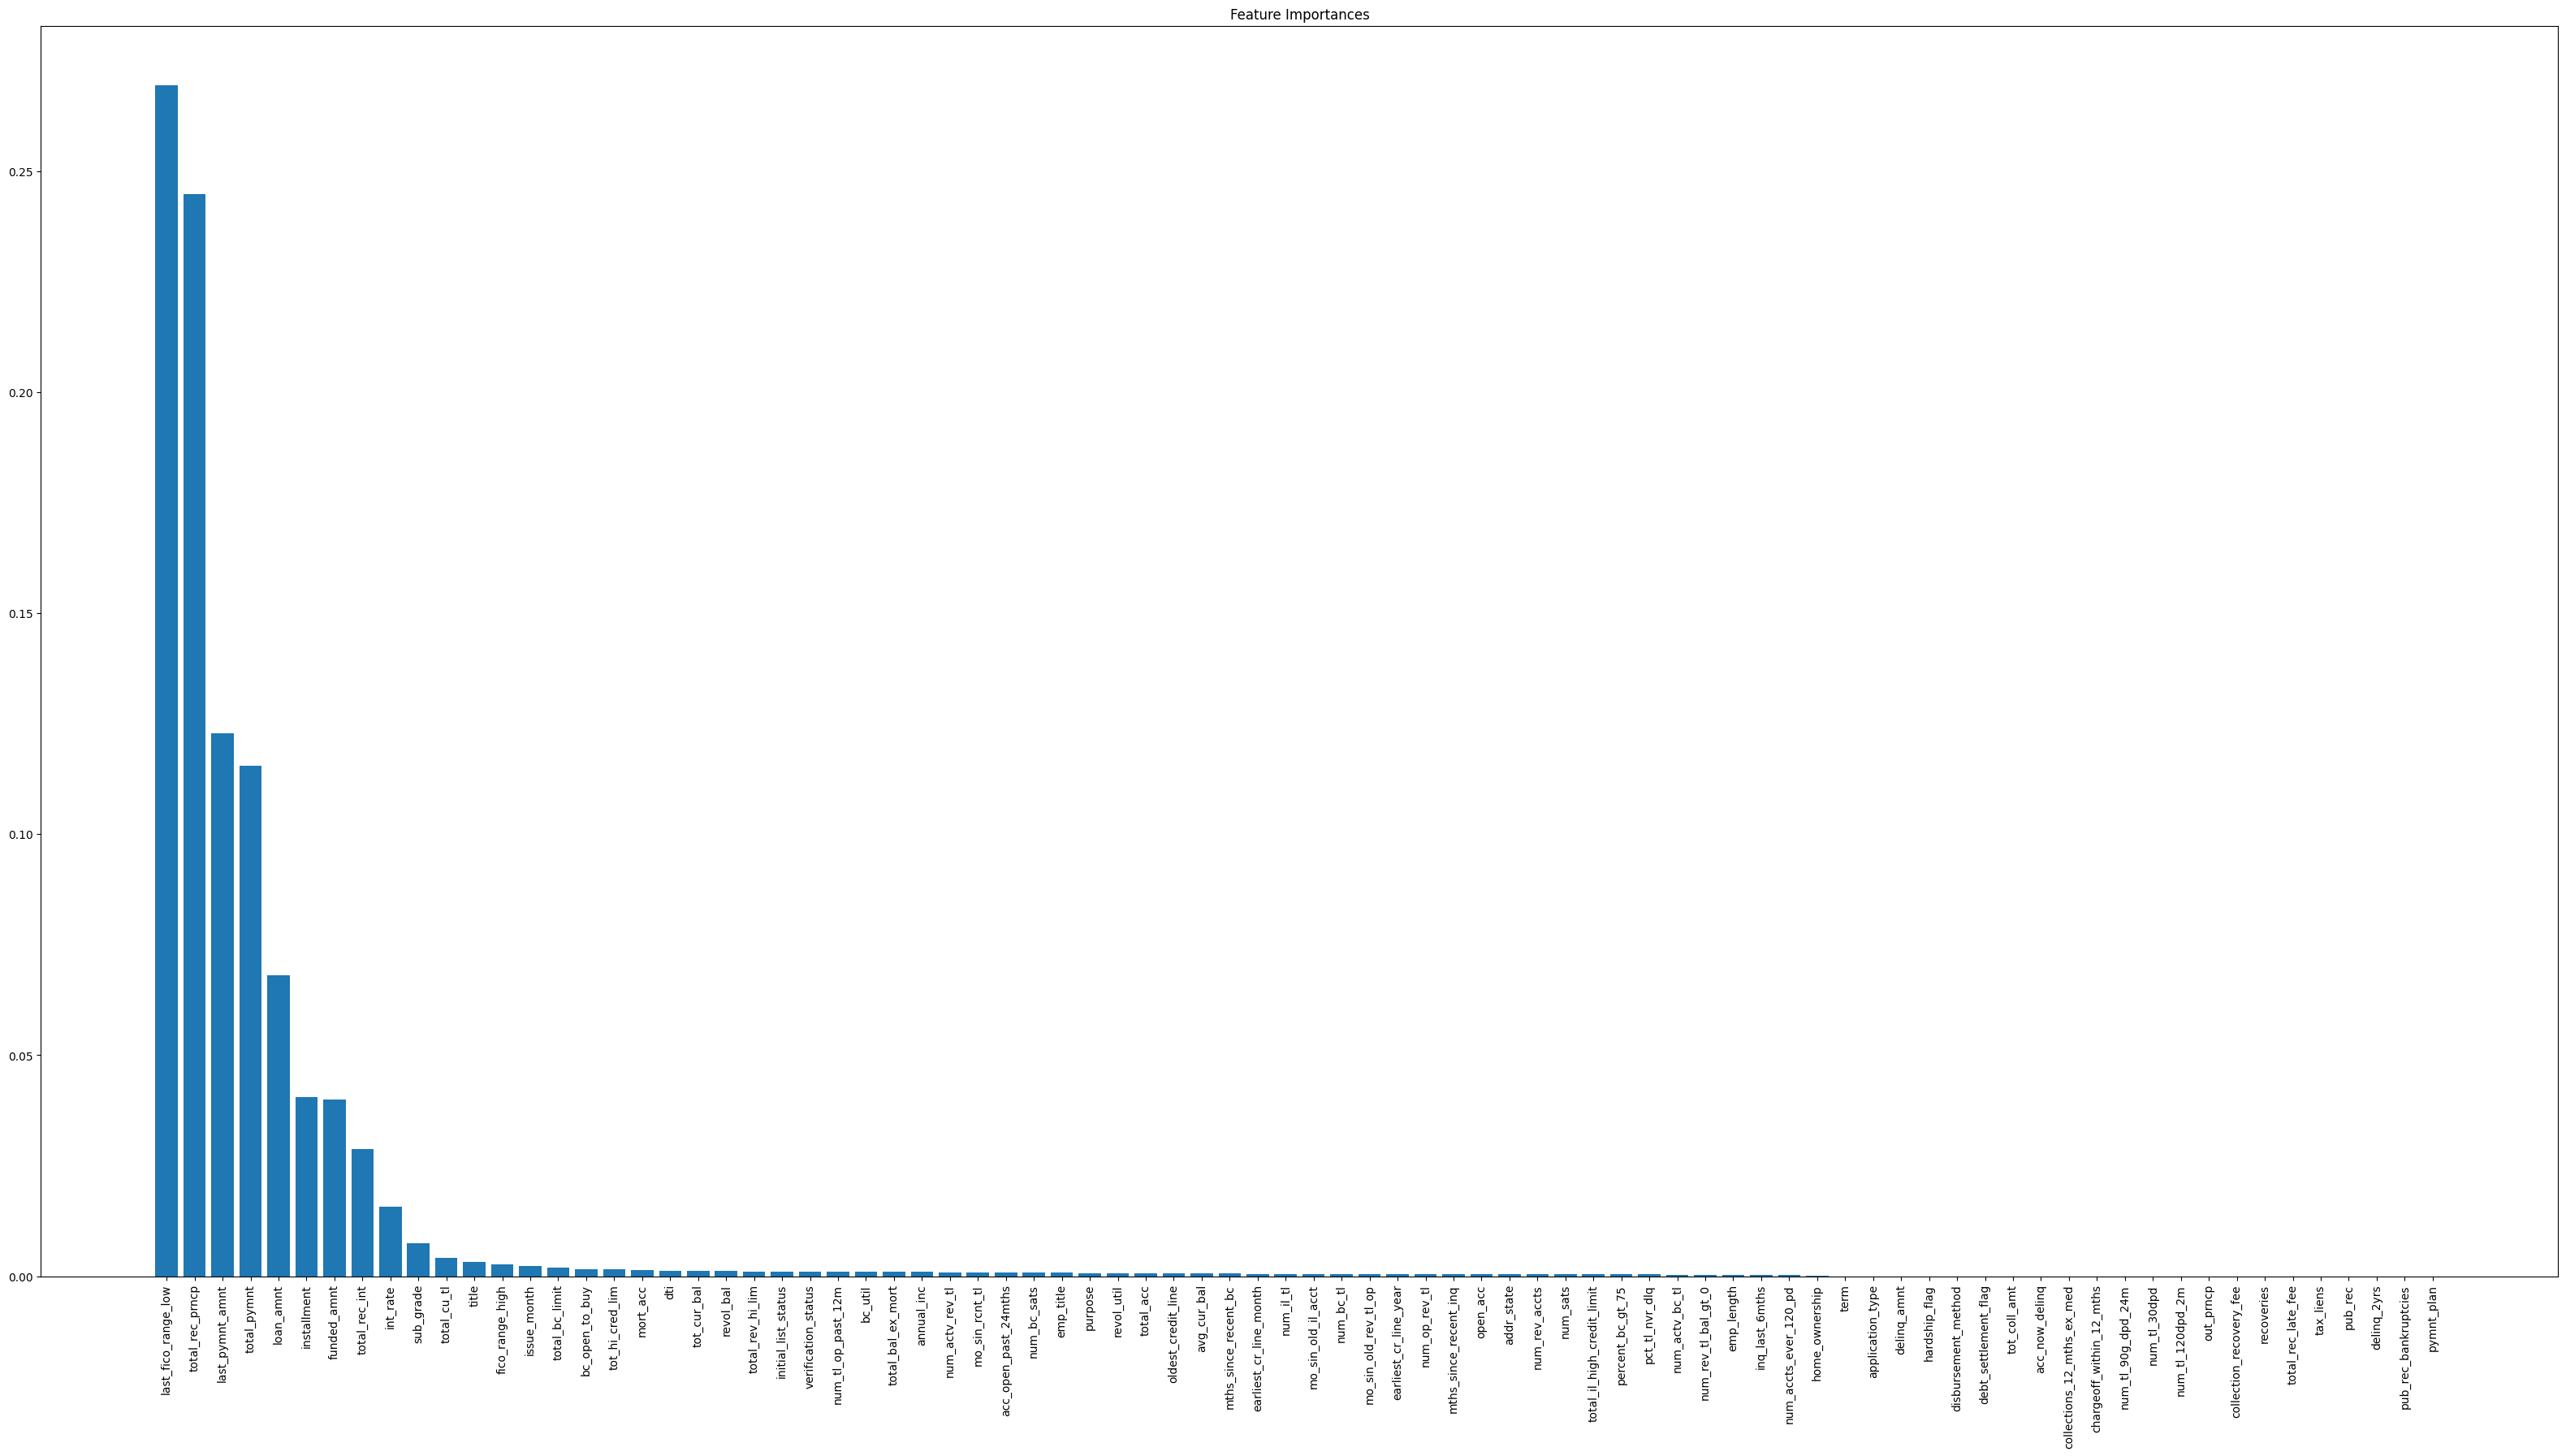

Selected features based on 95.0% cumulative importance:


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# using the`feature_importances`
feature_importances = list(zip(testingSet.columns, randomforestclass.featureImportances))
importances_df = pd.DataFrame(feature_importances, columns=["Features", "featureImportances"])
importances_df = importances_df.sort_values(by="featureImportances", ascending=False)


# Plotting feature importances
plt.figure(figsize=(40, 20))
plt.bar(importances_df["Features"], importances_df["featureImportances"])
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.show()

# Cumulative importance
importances_df['cumulative_importance'] = importances_df['featureImportances'].cumsum()

# Setting a threshold (e.g., 95% cumulative importance)
threshold = 0.95
important_features = importances_df[importances_df['cumulative_importance'] <= threshold]['Features']

print(f'Selected features based on {threshold*100}% cumulative importance:')
#print(important_features)

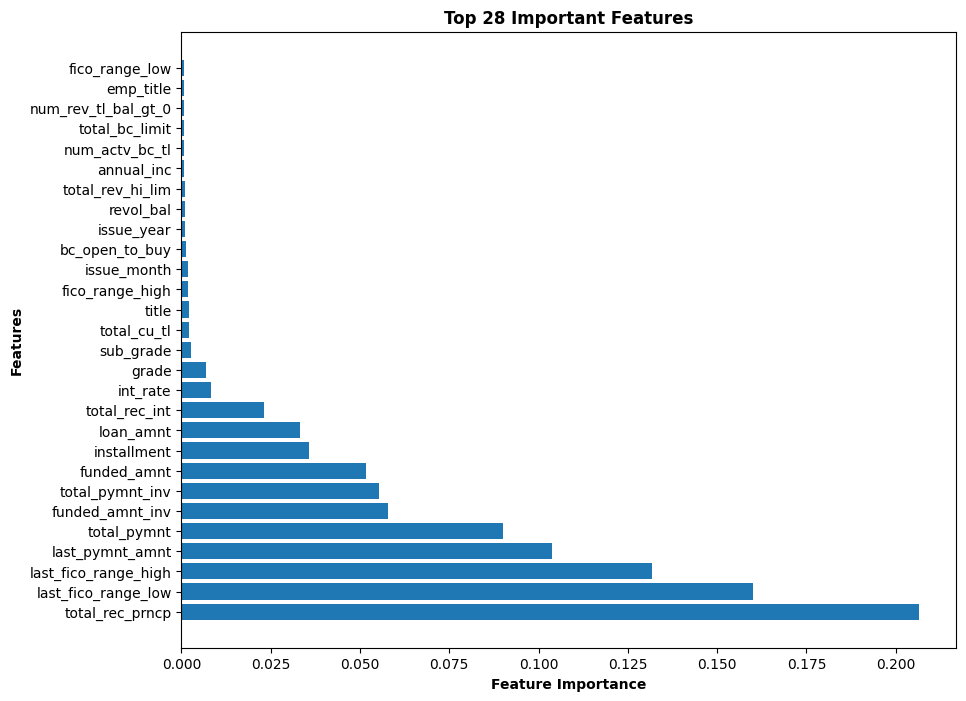

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# using the`feature_importances`
feature_importances = list(zip(testingSet.columns, randomforestclass.featureImportances))
importances_df = pd.DataFrame(feature_importances, columns=["Features", "featureImportances"])
importances_df = importances_df.sort_values(by="featureImportances", ascending = False)

# Select the top 28 features
top_28_importances = importances_df.head(28)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_28_importances['Features'], top_28_importances['featureImportances'])
plt.xlabel('Feature Importance', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.title('Top 28 Important Features', fontweight='bold')
# plt.tight_layout()
plt.show()

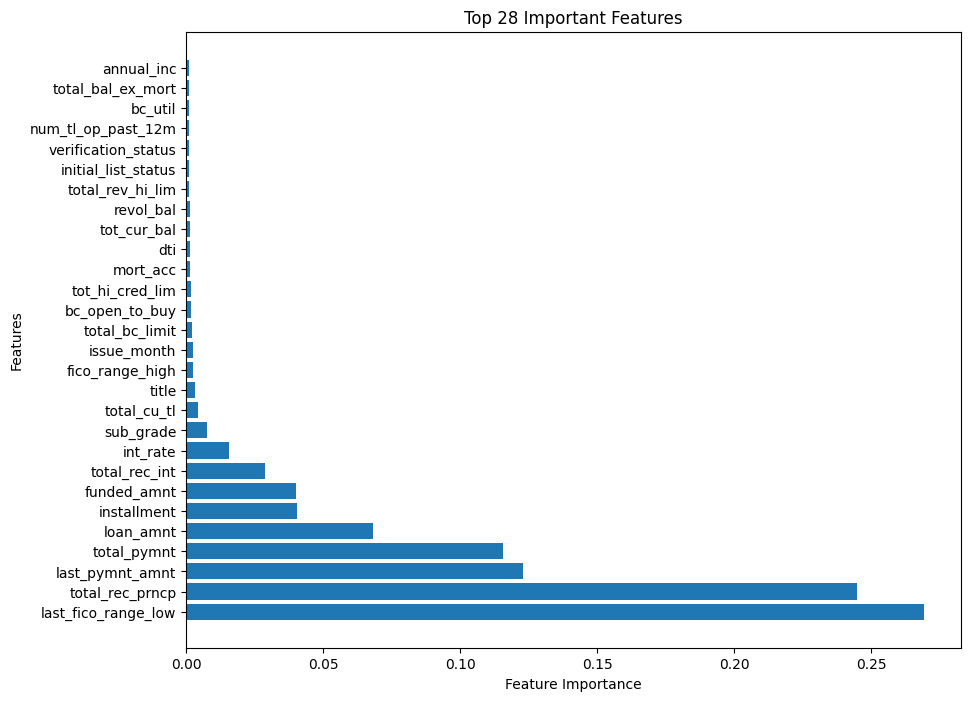

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# using the`feature_importances`
feature_importances = list(zip(testingSet.columns, randomforestclass.featureImportances))
importances_df = pd.DataFrame(feature_importances, columns=["Features", "featureImportances"])
importances_df = importances_df.sort_values(by="featureImportances", ascending = False)

# Select the top 28 features
top_28_importances = importances_df.head(28)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_28_importances['Features'], top_28_importances['featureImportances'])
plt.xlabel('Feature Importance', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.title('Top 28 Important Features', fontweight='bold')
# plt.tight_layout()
plt.show()

In [ ]:
# selecting top K features
top_k = 28  # Specifying the number of top features to print
top_k_features = importances_df.head(top_k)['Features']

print(f'Top {top_k} features:')
print(top_k_features)

Top 28 features:
24    last_fico_range_low
18        total_rec_prncp
23        last_pymnt_amnt
17            total_pymnt
0               loan_amnt
4             installment
1             funded_amnt
19          total_rec_int
3                int_rate
66              sub_grade
30            total_cu_tl
72                  title
9         fico_range_high
79            issue_month
63         total_bc_limit
33         bc_open_to_buy
61        tot_hi_cred_lim
40               mort_acc
7                     dti
28            tot_cur_bal
13              revol_bal
29       total_rev_hi_lim
74    initial_list_status
69    verification_status
56     num_tl_op_past_12m
34                bc_util
62      total_bal_ex_mort
6              annual_inc
Name: Features, dtype: object


Size of training data is 955063 by 92
Size of test data is 410078 by 92



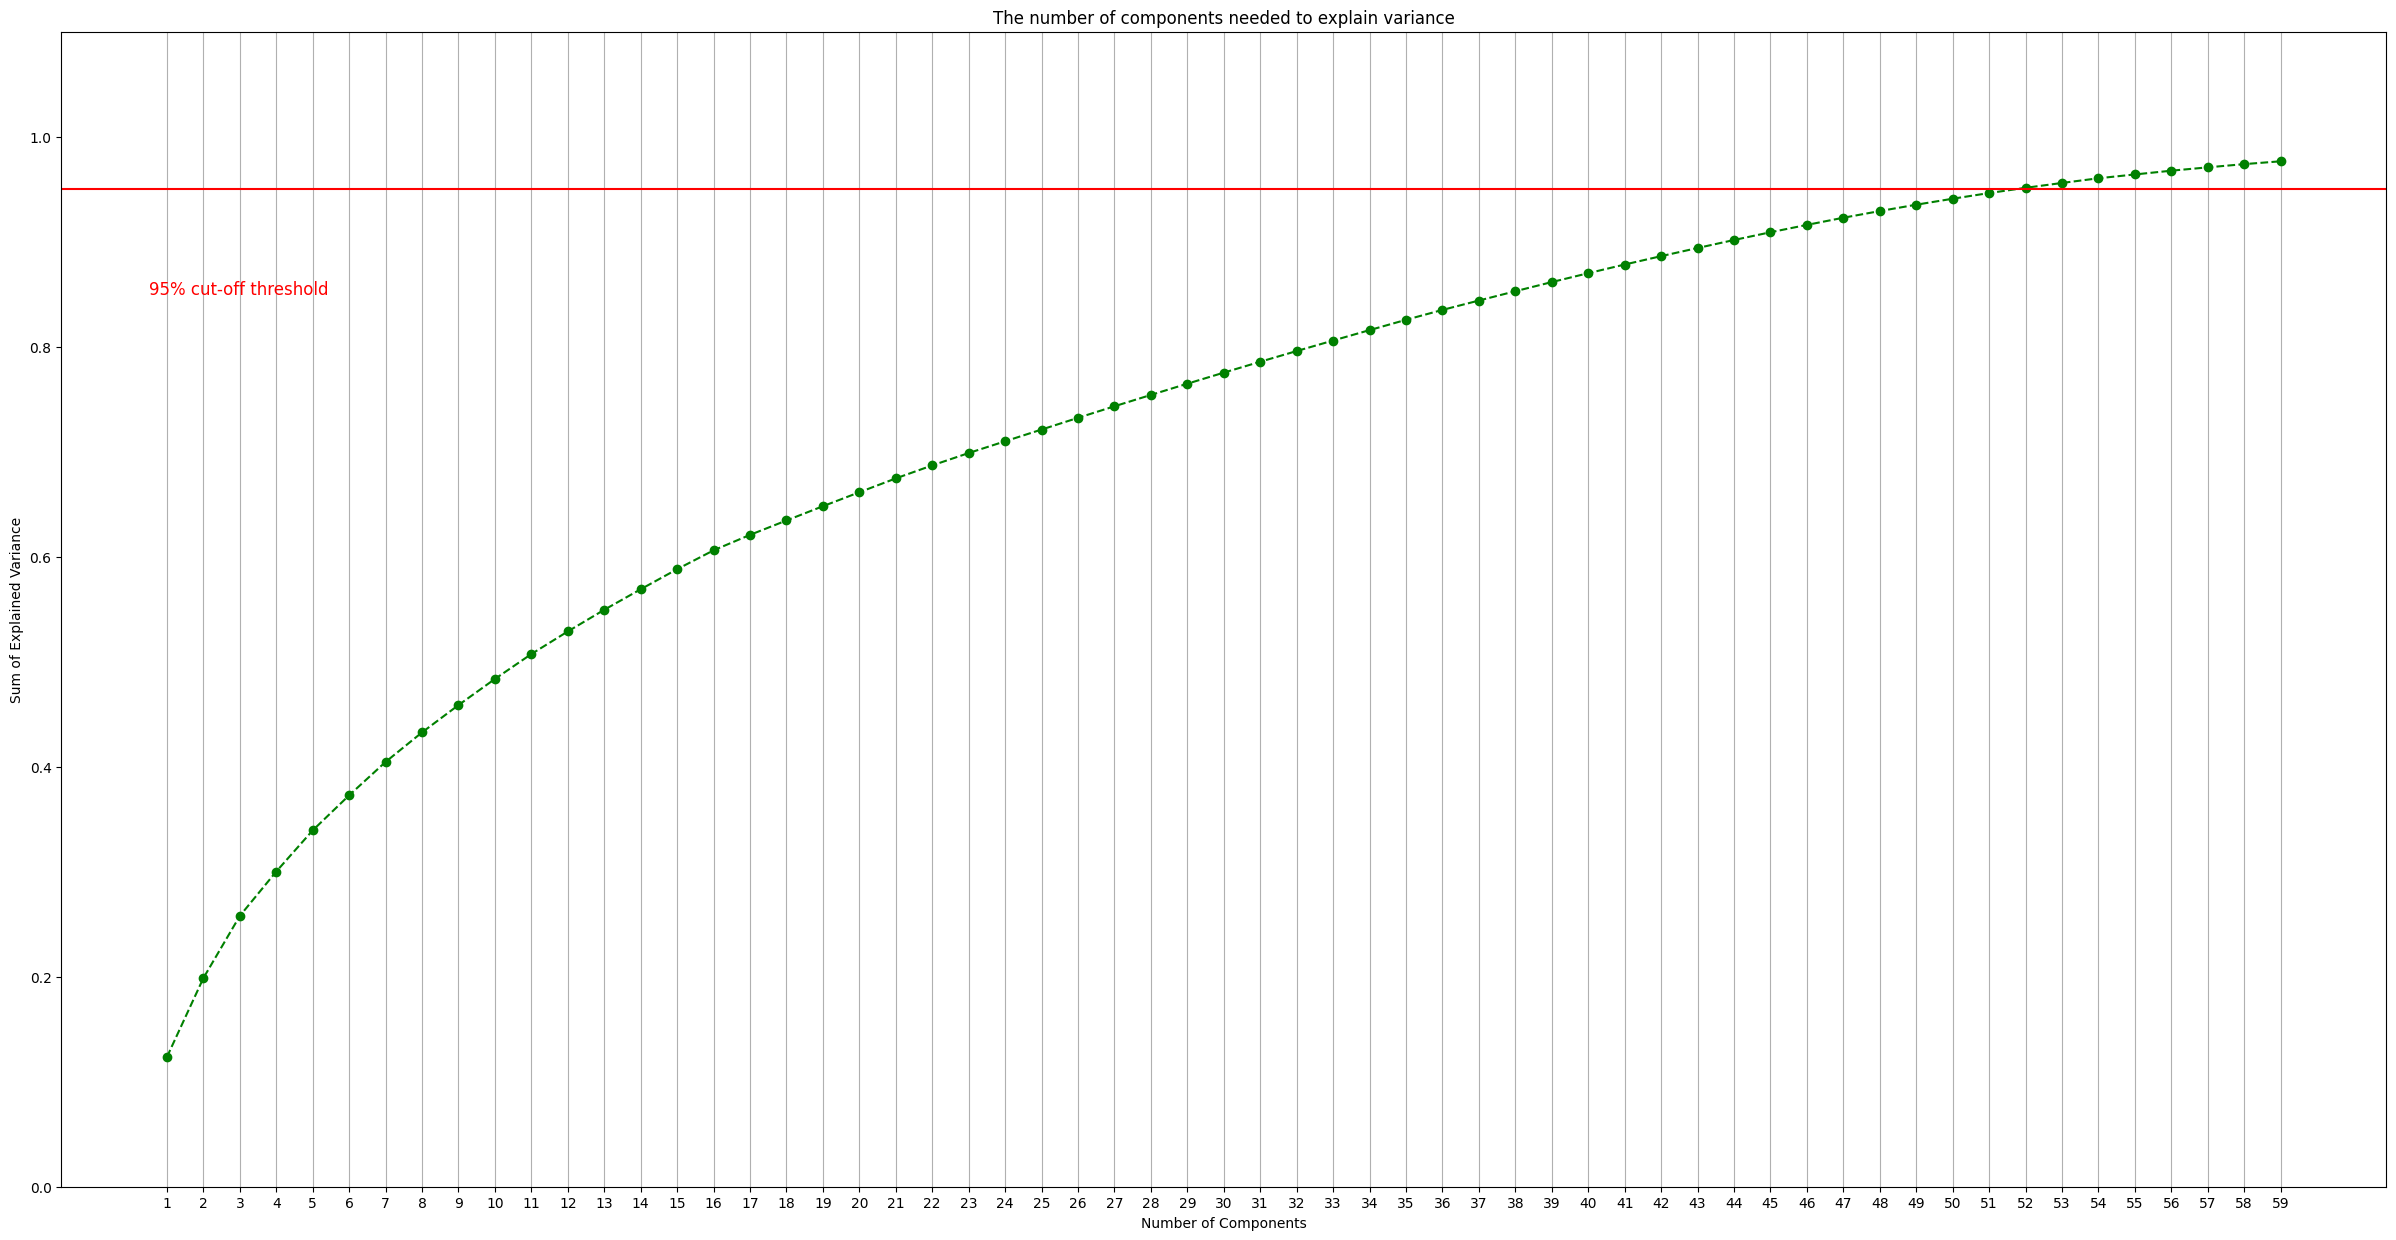

In [ ]:

dataset_2 = dataset.select('*') # creating  a copy of the dataset

vector_assembler = VectorAssembler(inputCols= [x for x in dataset_2.columns if x != 'label'], outputCol="features")
dataset_2 = vector_assembler.transform(dataset_2)

splits = dataset_2.randomSplit([0.70, 0.30], seed = 777)
train_data = splits[0]
test_data = splits[1]

print(f"Size of training data is {train_data.count()} by {len(train_data.columns)}")
print(f"Size of test data is {test_data.count()} by {len(test_data.columns)}")
print()

# Create and apply RobustScaler
#scaler = RobustScaler(inputCol = 'features', outputCol = 'scaledFeatures').fit(train_data)
scaler =  RobustScaler(inputCol='features', outputCol='scaledFeatures').fit(train_data)
scaled_train_df = scaler.transform(train_data)
scaled_test_df = scaler.transform(test_data)

y_ = []

for i in range(1,60):

  pca = PCA(k=i, inputCol='scaledFeatures', outputCol='pcaFeatures').fit(scaled_train_df)

  y = pca.explainedVariance.sum()
  y_.append(y)

fig, ax = plt.subplots(figsize=(30,15))
xi = np.arange(1, 60)
ax.set_ylim(0.0,1.1)
ax.plot(xi, np.array(y_), marker='o', linestyle='--', color='green')

ax.set_xlabel('Number of Components')
ax.set_xticks(np.arange(1, 60, step=1))
ax.set_ylabel('Sum of Explained Variance')

ax.set_title('The number of components needed to explain variance')

ax.axhline(y=0.95, color='r', linestyle='-')
ax.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)

ax.grid(axis='x')
plt.show()

# **2. Model Selection and Implementation**

A final training and testing datasets is created by applying Principal Component Analysis (PCA) to extract the most relevant features for theclassification. Performance metrics are measured to ensure there is no decline in model performance following feature extraction.

Due to class imbalance, weighted precision and recall metrics for each class label are assessed individually, with a focuse on the default label, which has the fewest instances, in other to gain a comprehensive understanding of the model's performance across all class labels.


**Training and Testing Steps:**
Steps to ensure dataset is correctly prepared and transformed for model training and evaluation.
**Stratified Split**: Ensures that the training and testing datasets maintain the same class distribution as the original dataset.
**Feature Transformation Pipeline**: Combines vector assembly, scaling, and PCA into a single transformation pipeline, which is then applied to both training and testing data for consistency.

#### Model Training

In [ ]:
dataset = spark.read.format("csv").option("inferSchema", True).option("header", True).load('/content/drive/MyDrive/MSc/ProjectData/dataframe1-stringIndexedDouble_070824')
#dataset.printSchema()

In [ ]:
dataset.show(5)

+---------+-----------+---------------+----+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+-----------+----------+------------------+------------------+----------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------+-------------------+--------------------------+----------------+--------------+------------+-----------+----------------+-----------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+---

In [ ]:
# obtaining a stratified split of all class labels in the training and test sets
Default = dataset.filter(dataset["label"] == 0.0) #zeros = Default
Default = Default.randomSplit([0.8, 0.2], seed=777)

non_Default = dataset.filter(dataset["label"] == 1.0) #ones = non_Default
non_Default = non_Default.randomSplit([0.8, 0.2], seed=777)

train_Set = Default[0].union(non_Default[0])
test_Set = Default[1].union(non_Default[1])


# Applying vector assembler and Robust scaler
# Create a VectorAssembler with all input features
assembler = VectorAssembler(inputCols=[column for column in train_Set.columns if column != "label"], outputCol="features")
# Create and apply RobustScaler
scaler = RobustScaler(inputCol = 'features', outputCol = 'scaledFeature')
# PCA features
pca_scaled = PCA(k=22, inputCol="scaledFeature", outputCol="scaledFeatures")

pipeline = Pipeline(stages=[assembler, scaler, pca_scaled]).fit(train_Set)

training_Set = pipeline.transform(train_Set)

testing_Set = pipeline.transform(test_Set)

In [ ]:
# obtaining a stratified split of all class labels in the training and test sets
Default = dataset.filter(dataset["label"] == 0.0) #zeros = Default
Default = Default.randomSplit([0.8, 0.2], seed=777)

non_Default = dataset.filter(dataset["label"] == 1.0) #ones = non_Default
non_Default = non_Default.randomSplit([0.8, 0.2], seed=777)

train_Set = Default[0].union(non_Default[0])
test_Set = Default[1].union(non_Default[1])


# Applying vector assembler and Robust scaler
# Create a VectorAssembler with all input features
assembler = VectorAssembler(inputCols=[column for column in train_Set.columns if column != "label"], outputCol="features")
# Create and apply RobustScaler
scaler = RobustScaler(inputCol = 'features', outputCol = 'scaledFeatures')
# PCA features
#pca_scaled = PCA(k=52, inputCol="scaledFeature", outputCol="FeaturesPCA") #PCA features has slightly lower accuracy

pipeline = Pipeline(stages=[assembler, scaler]).fit(train_Set)

training_Set = pipeline.transform(train_Set)

testing_Set = pipeline.transform(test_Set)

In [ ]:
from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    MultilayerPerceptronClassifier,
    LinearSVC
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import numpy as np

# Define models and their names
models = [
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    MultilayerPerceptronClassifier,
    LinearSVC
]

model_names = [
    "LogisticRegression",
    "DecisionTreeClassifier",
    "RandomForestClassifier",
    "GradientBoosting",
    "MLP",
    "LinearSVC"]

# Number of classes
num_classes = 2

# Loop through each model
for model, name in zip(models, model_names):
    if model == LogisticRegression:
        modeller = model(
            featuresCol="scaledFeatures",
            labelCol="label",
            predictionCol=f"{name}Prediction",
        ).fit(training_Set)
    elif model == MultilayerPerceptronClassifier:
        # Specify layers for the MLP: [input_size, hidden_layers..., output_size]
        layers = [len(training_Set.select("scaledFeatures").first()[0]), 64, 32, num_classes]  # Updated layer structure
        modeller = model(
            featuresCol="scaledFeatures",
            labelCol="label",
            predictionCol=f"{name}Prediction",
            layers=layers,
            blockSize=128,
            seed=777,
            maxIter=100
        ).fit(training_Set)
    elif model == LinearSVC:
        # LinearSVC for binary classification
        modeller = model(
            featuresCol="scaledFeatures",
            labelCol="label",
            predictionCol=f"{name}Prediction",
            maxIter=100,
            regParam=0.1,
            tol=1e-6
        ).fit(training_Set)
    elif model == RandomForestClassifier:
        # Random Forest specific parameters
        modeller = model(
            featuresCol="scaledFeatures",
            labelCol="label",
            predictionCol=f"{name}Prediction",
            numTrees=30,
            maxDepth=15,
            seed=777
        ).fit(training_Set)
    elif model == GBTClassifier:
        # Gradient Boosted Trees specific parameters
        modeller = model(
            featuresCol="scaledFeatures",
            labelCol="label",
            predictionCol=f"{name}Prediction",
            maxDepth=15,
            maxIter=10,  # GBT uses maxIter instead of numTrees
            seed=777
        ).fit(training_Set)
    else:
        # For other models
        modeller = model(
            featuresCol="scaledFeatures",
            labelCol="label",
            predictionCol=f"{name}Prediction",
            seed=777
        ).fit(training_Set)

    # Make predictions
    train_data_predictions = modeller.transform(training_Set)
    test_data_predictions = modeller.transform(testing_Set)

    # Evaluate the model
    accuracy = MulticlassClassificationEvaluator(
        predictionCol=f"{name}Prediction",
        labelCol="label",
        metricName="accuracy"
    ).evaluate(test_data_predictions)

    f1_score = MulticlassClassificationEvaluator(
        predictionCol=f"{name}Prediction",
        labelCol="label",
        metricName="f1"
    ).evaluate(test_data_predictions)

    precision = MulticlassClassificationEvaluator(
        predictionCol=f"{name}Prediction",
        labelCol="label",
        metricName="weightedPrecision"
    ).evaluate(test_data_predictions)

    recall = MulticlassClassificationEvaluator(
        predictionCol=f"{name}Prediction",
        labelCol="label",
        metricName="weightedRecall"
    ).evaluate(test_data_predictions)

    # Precision and recall for specific classes
    non_default_precision = MulticlassClassificationEvaluator(
        predictionCol=f"{name}Prediction",
        labelCol="label",
        metricLabel=0.0,
        metricName="precisionByLabel"
    ).evaluate(test_data_predictions)

    non_default_recall = MulticlassClassificationEvaluator(
        predictionCol=f"{name}Prediction",
        labelCol="label",
        metricLabel=0.0,
        metricName="recallByLabel"
    ).evaluate(test_data_predictions)

    default_precision = MulticlassClassificationEvaluator(
        predictionCol=f"{name}Prediction",
        labelCol="label",
        metricLabel=1.0,
        metricName="precisionByLabel"
    ).evaluate(test_data_predictions)

    default_recall = MulticlassClassificationEvaluator(
        predictionCol=f"{name}Prediction",
        labelCol="label",
        metricLabel=1.0,
        metricName="recallByLabel"
    ).evaluate(test_data_predictions)

    # ROC AUC evaluation
    if model == LinearSVC or model == LogisticRegression:
        # For binary classifiers
        binary_evaluator = BinaryClassificationEvaluator(
            rawPredictionCol="rawPrediction",
            labelCol="label",
            metricName="areaUnderROC"
        )

        roc_auc = binary_evaluator.evaluate(test_data_predictions)

        print(f'{name} ROC AUC Score is {roc_auc * 100:.2f}%')

    else:
        roc_auc = None

    # Print metrics
    print(f'{name} accuracy:  {accuracy * 100:.2f}%')
    print(f'{name} f1_score:  {f1_score * 100:.2f}%')
    print(f'{name} precision: {precision * 100:.2f}%')
    print(f'{name} recall:  {recall * 100:.2f}%')
    print()
    print(f'{name} precision for Non_Default is {non_default_precision * 100:.2f}%')
    print(f'{name} recall for Non_Default is {non_default_recall * 100:.2f}%')
    print()
    print(f'{name} precision for Default is {default_precision * 100:.2f}%')
    print(f'{name} recall for Default is {default_recall * 100:.2f}%')
    print()
    if roc_auc is not None:
        print(f'{name} ROC AUC Score: {roc_auc * 100:.2f}%')

    print("---------------------------------------------------------------------")
    print()


LogisticRegression ROC AUC Score is 99.98%
LogisticRegression accuracy:  99.97%
LogisticRegression f1_score:  99.97%
LogisticRegression precision: 99.97%
LogisticRegression recall:  99.97%

LogisticRegression precision for Non_Default is 100.00%
LogisticRegression recall for Non_Default is 99.86%

LogisticRegression precision for Default is 99.96%
LogisticRegression recall for Default is 100.00%

LogisticRegression ROC AUC Score: 99.98%
---------------------------------------------------------------------

DecisionTreeClassifier accuracy:  96.16%
DecisionTreeClassifier f1_score:  96.12%
DecisionTreeClassifier precision: 96.12%
DecisionTreeClassifier recall:  96.16%

DecisionTreeClassifier precision for Non_Default is 93.33%
DecisionTreeClassifier recall for Non_Default is 88.47%

DecisionTreeClassifier precision for Default is 96.88%
DecisionTreeClassifier recall for Default is 98.27%

---------------------------------------------------------------------

RandomForestClassifier accurac

---
# **3. Model Parameter Tuning**
---


#### GTB is a prefered model for parameter tuning and evaluation due to imbalance dataset we used for modelling. Though LR has high accuracy,  It is particularly useful if the dataset is not very imbalanced and the relationships between features and the target are relatively simple.

In [ ]:
#Due to imbalanced dataset, we employed stratified splitting to ensure quantitative distribution

# obtaining a stratified split of all class labels in the training and test sets
Default = dataset.filter(dataset["label"] == 0.0) #zeros = Default
Default = Default.randomSplit([0.8, 0.2], seed=777)

non_Default = dataset.filter(dataset["label"] == 1.0) #ones = non_Default
non_Default = non_Default.randomSplit([0.8, 0.2], seed=777)

training_data = Default[0].union(non_Default[0])
testing_data = Default[1].union(non_Default[1])

#print(f"The training set contains {training_data.count()} records and {len(training_data.columns)} features in the train dataset")
#print(f"The testing set contains {testing_data.count()} records and {len(testing_data.columns)} features in the test dataset")

# Applying vector assembler and Robust scaler
# Create a VectorAssembler with all input features
assembler = VectorAssembler(inputCols=[column for column in training_data.columns if column != "label"], outputCol="features")
# Create and apply RobustScaler
scaler = RobustScaler(inputCol = 'features', outputCol = 'scaledFeatures')
# PCA features
#pca_scaled = PCA(k=22, inputCol="scaledFeature", outputCol="FeaturesPCA")


pipelineScaled = Pipeline(stages=[assembler, scaler]).fit(training_data)

# Transform training and testing data
training_data = pipelineScaled.transform(training_data)
testing_data = pipelineScaled.transform(testing_data)

In [ ]:
train_Set = training_data.select('*')
test_Set = testing_data.select('*')

In [ ]:
# # To train a subset of the train data to avoid model overfitting
# splits = training_Set.randomSplit([0.7, 0.3], seed=777)
# train_Set = splits[0]
# test_Set = splits[1]

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import random

# Define the evaluators for different metrics
evaluator_accuracy = MulticlassClassificationEvaluator(
    predictionCol="GBTClassifierPrediction",
    labelCol="label",
    metricName="accuracy"
)
evaluator_precision = MulticlassClassificationEvaluator(
    predictionCol="GBTClassifierPrediction",
    labelCol="label",
    metricName="weightedPrecision"
)
evaluator_recall = MulticlassClassificationEvaluator(
    predictionCol="GBTClassifierPrediction",
    labelCol="label",
    metricName="weightedRecall"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    predictionCol="GBTClassifierPrediction",
    labelCol="label",
    metricName="f1"
)

# Define hyperparameter ranges
maxIter = [10, 20, 30]
maxDepth = [5, 10, 15]

# Initialize best metrics and parameters
best_metrics = {
    'accuracy': 0.0,
    'precision': 0.0,
    'recall': 0.0,
    'f1': 0.0
}
best_params = {
    'maxIter': None,
    'maxDepth': None
}

# Perform random search
num_samples = 5  # Number of random samples to try
for _ in range(num_samples):
    # Randomly sample hyperparameters
    sampled_maxIter = random.choice(maxIter)
    sampled_maxDepth = random.choice(maxDepth)

    # Initialize the GBTClassifier with the sampled parameters
    gbt = GBTClassifier(
        featuresCol="scaledFeatures",
        labelCol="label",
        predictionCol="GBTClassifierPrediction",
        seed=777,
        maxIter=sampled_maxIter,
        maxDepth=sampled_maxDepth
    )

    # Fit the model
    gbtModel = gbt.fit(train_Set)

    # Make predictions
    predictions = gbtModel.transform(test_Set)

    # Evaluate metrics
    accuracy = evaluator_accuracy.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    # Check if the current model is the best so far based on accuracy
    if accuracy > best_metrics['accuracy']:
        best_metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        best_params = {
            'maxIter': sampled_maxIter,
            'maxDepth': sampled_maxDepth
        }

# Print the best parameters and metrics in percentage format with four decimal places
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_metrics['accuracy'] * 100:.4f}%")
print(f"Best Precision: {best_metrics['precision'] * 100:.4f}%")
print(f"Best Recall: {best_metrics['recall'] * 100:.4f}%")
print(f"Best F1 Score: {best_metrics['f1'] * 100:.4f}%")


Best Parameters: {'maxIter': 20, 'maxDepth': 10}
Best Accuracy: 99.6892%
Best Precision: 99.6896%
Best Recall: 99.6892%
Best F1 Score: 99.6885%


---
# **4. Model Evaluation and AUC Calculation**
---

*GBT Evaluation as the best performing model**

In [ ]:
dataset = spark.read.format("csv").option("inferSchema", True).option("header", True).load('/content/drive/MyDrive/MSc/ProjectData/dataframe1-stringIndexedDouble_070824')
#dataset.printSchema()

In [ ]:
# obtaining a stratified split of all class labels in the training and test sets
Default = dataset.filter(dataset["label"] == 0.0) #zeros = Default
Default = Default.randomSplit([0.8, 0.2], seed=777)

non_Default = dataset.filter(dataset["label"] == 1.0) #ones = non_Default
non_Default = non_Default.randomSplit([0.8, 0.2], seed=777)

train_Set = Default[0].union(non_Default[0])
test_Set = Default[1].union(non_Default[1])


# Applying vector assembler
assembler = VectorAssembler(inputCols=[column for column in train_Set.columns if column != "label"], outputCol="features")

# apply RobustScaler
scaler = RobustScaler(inputCol = 'features', outputCol = 'scaledFeatures')

# apply PCA and create a pipeline
#pca_scaled = PCA(k=22, inputCol="scaledFeature", outputCol="FeaturesPCA")

pipeline = Pipeline(stages=[assembler, scaler]).fit(train_Set)

training_Set = pipeline.transform(train_Set)

testing_Set = pipeline.transform(test_Set)

In [ ]:
# Fit the GBT model
model = GBTClassifier(featuresCol="scaledFeatures", labelCol="label", predictionCol="finalPrediction", seed=777, maxIter=20, maxDepth=10).fit(training_Set)

# Transform the datasets
final_training_data_predictions = model.transform(training_Set)
final_testing_data_predictions = model.transform(testing_Set)

# Evaluators for accuracy, F1 score, precision, and recall
accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol="finalPrediction", labelCol="label", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(predictionCol="finalPrediction", labelCol="label", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(predictionCol="finalPrediction", labelCol="label", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(predictionCol="finalPrediction", labelCol="label", metricName="weightedRecall")

# Evaluate metrics
accuracy = accuracy_evaluator.evaluate(final_training_data_predictions)
f1_score = f1_evaluator.evaluate(final_testing_data_predictions)
precision = precision_evaluator.evaluate(final_testing_data_predictions)
recall = recall_evaluator.evaluate(final_testing_data_predictions)

# Precision and Recall for each class
Default_precision = MulticlassClassificationEvaluator(predictionCol="finalPrediction", labelCol="label", metricLabel=0.0, metricName="precisionByLabel").evaluate(final_testing_data_predictions)
Default_recall = MulticlassClassificationEvaluator(predictionCol="finalPrediction", labelCol="label", metricLabel=0.0, metricName="recallByLabel").evaluate(final_testing_data_predictions)

Non_Default_precision = MulticlassClassificationEvaluator(predictionCol="finalPrediction", labelCol="label", metricLabel=1.0, metricName="precisionByLabel").evaluate(final_testing_data_predictions)
Non_Default_recall = MulticlassClassificationEvaluator(predictionCol="finalPrediction", labelCol="label", metricLabel=1.0, metricName="recallByLabel").evaluate(final_testing_data_predictions)

# Print metrics
print(f"Accuracy is {accuracy * 100:.2f}%")
print(f"F1 Score is {f1_score * 100:.2f}%")
print(f"Precision is {precision * 100:.2f}%")
print(f"Recall is {recall * 100:.2f}%")
print()
print(f"Precision for Default is {Default_precision * 100:.2f}%")
print(f"Recall for Default is {Default_recall * 100:.2f}%")
print()
print(f"Precision for Non_Default is {Non_Default_precision * 100:.2f}%")
print(f"Recall for Non_Default is {Non_Default_recall * 100:.2f}%")
print()
print("******************************************************")

Accuracy is 99.76%
F1 Score is 99.69%
Precision is 99.69%
Recall is 99.69%

Precision for Default is 99.72%
Recall for Default is 98.83%

Precision for Non_Default is 99.68%
Recall for Non_Default is 99.92%

******************************************************


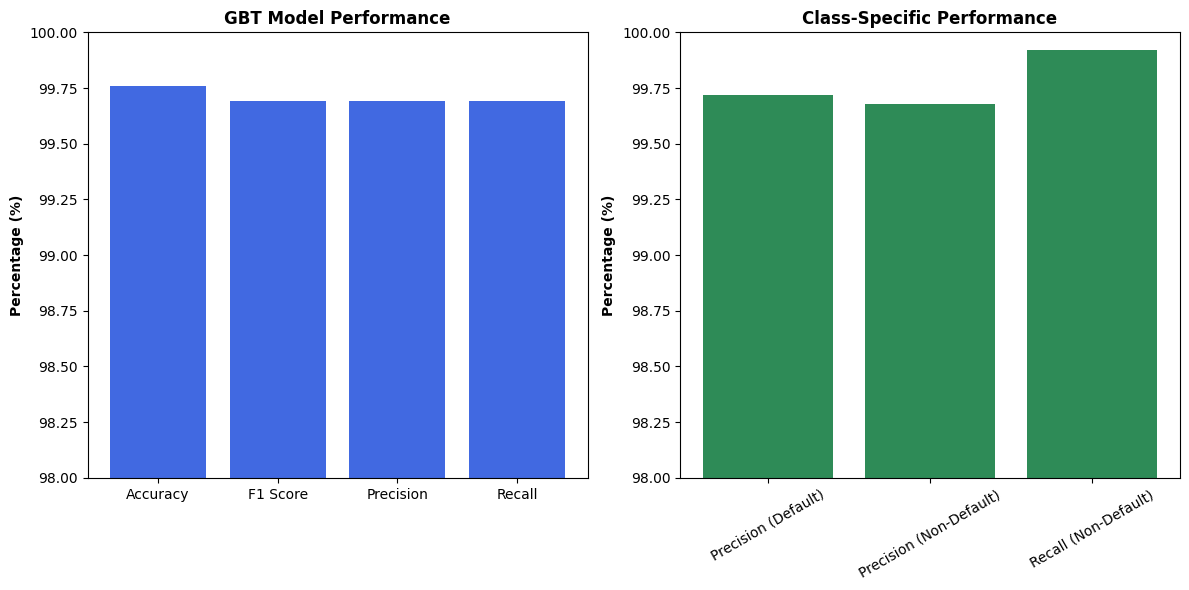

In [ ]:
# Model performance metrics
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
values = [99.76, 99.69, 99.69, 99.69]

# Class-specific metrics
class_metrics = {
    'Precision (Default)': 99.72,
    #'Recall (Default)': 98.83,
    'Precision (Non-Default)': 99.68,
    'Recall (Non-Default)': 99.92
}

# Create figure and axis
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for overall metrics
ax[0].bar(metrics, values, color='royalblue')
ax[0].set_ylim([98, 100])
ax[0].set_title('GBT Model Performance', fontweight='bold')
ax[0].set_ylabel('Percentage (%)', fontweight='bold')

# Bar chart for class-specific metrics
ax[1].bar(class_metrics.keys(), class_metrics.values(), color='seagreen')
ax[1].set_ylim([98, 100])
ax[1].set_title('Class-Specific Performance', fontweight='bold')
ax[1].set_ylabel('Percentage (%)', fontweight='bold')
ax[1].tick_params(axis='x', rotation=30)


plt.tight_layout()
plt.show()

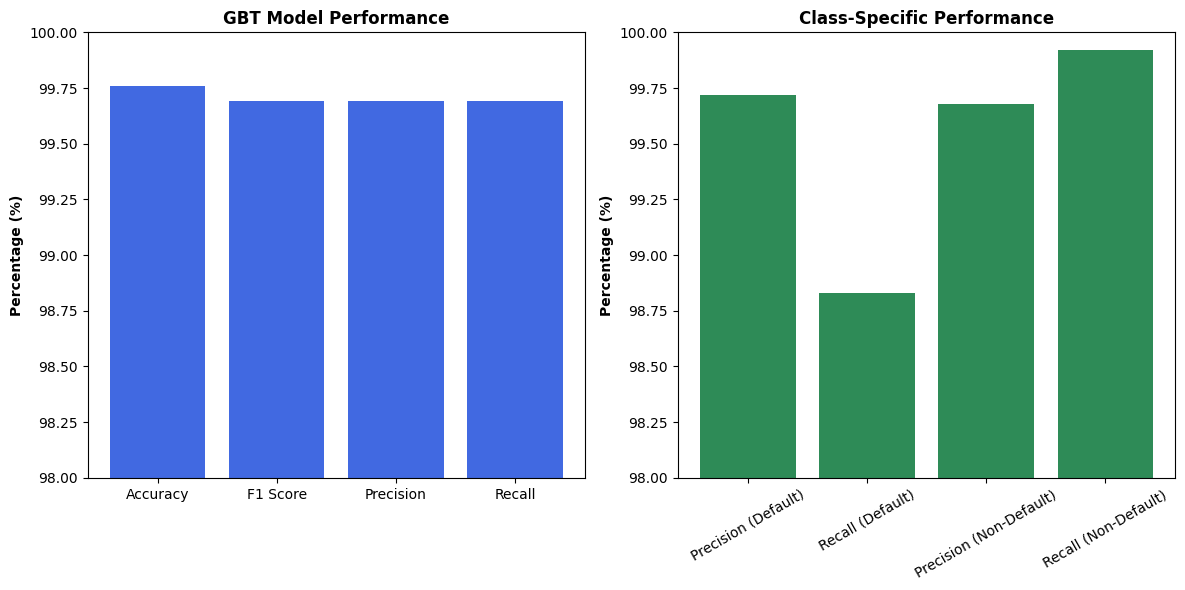

In [ ]:
# Model performance metrics
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
values = [99.76, 99.69, 99.69, 99.69]

# Class-specific metrics
class_metrics = {
    'Precision (Default)': 99.72,
    #'Recall (Default)': 98.83,
    'Precision (Non-Default)': 99.68,
    'Recall (Non-Default)': 99.92
}

# Create figure and axis
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for overall metrics
ax[0].bar(metrics, values, color='royalblue')
ax[0].set_ylim([98, 100])
ax[0].set_title('GBT Model Performance', fontweight='bold')
ax[0].set_ylabel('Percentage (%)', fontweight='bold')

# Bar chart for class-specific metrics
ax[1].bar(class_metrics.keys(), class_metrics.values(), color='seagreen')
ax[1].set_ylim([98, 100])
ax[1].set_title('Class-Specific Performance', fontweight='bold')
ax[1].set_ylabel('Percentage (%)', fontweight='bold')
ax[1].tick_params(axis='x', rotation=30)


plt.tight_layout()
plt.show()

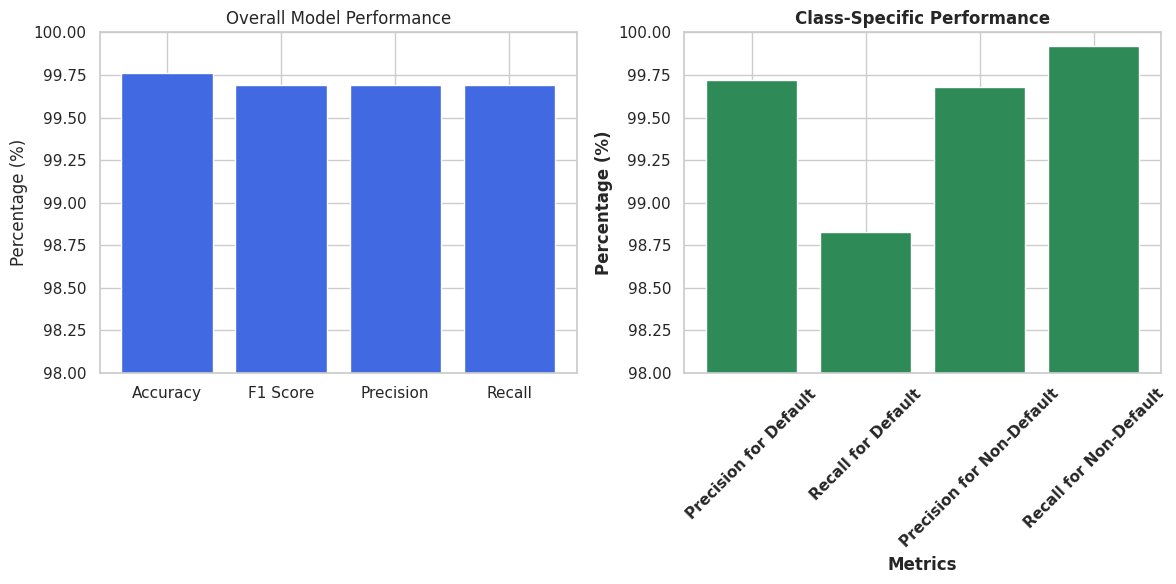

In [ ]:
# Model performance metrics
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
values = [99.76, 99.69, 99.69, 99.69]

# Class-specific metrics
class_metrics = {
    'Precision (Default)': 99.72,
    'Recall (Default)': 98.83,
    'Precision (Non-Default)': 99.68,
    'Recall (Non-Default)': 99.92
}

# Create figure and axis
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for overall metrics
ax[0].bar(metrics, values, color='royalblue')
ax[0].set_ylim([98, 100])
ax[0].set_title('Overall Model Performance')
ax[0].set_ylabel('Percentage (%)')

# Bar chart for class-specific metrics
ax[1].bar(class_metrics.keys(), class_metrics.values(), color='seagreen')
ax[1].set_ylim([98, 100])
ax[1].set_title('Class-Specific Performance', fontweight='bold')
ax[1].set_ylabel('Percentage (%)', fontweight='bold')

# Set xlabel and make it bold
ax[1].set_xlabel('Metrics', fontweight='bold')

# Rotate x-axis tick labels and make them bold
ax[1].tick_params(axis='x', rotation=45)
for tick in ax[1].get_xticklabels():
    tick.set_fontweight('bold')

plt.tight_layout()
plt.show()

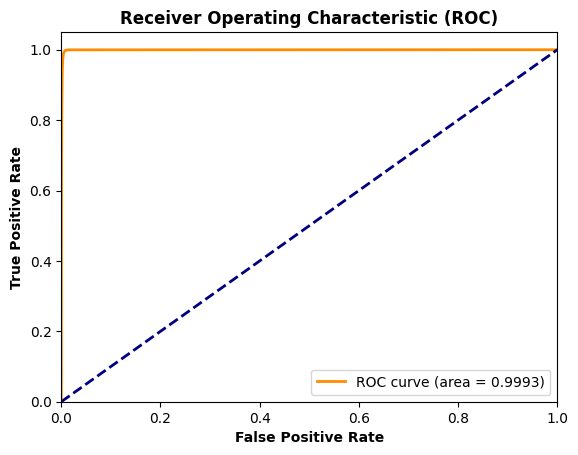

ROC AUC: 0.9993


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC and AUC Calculation
# Define evaluator for ROC and AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calculate ROC AUC
roc_auc = binary_evaluator.evaluate(final_testing_data_predictions)

# Collect predictions and labels for ROC curve
predictions_pd = final_testing_data_predictions.select("label", "rawPrediction").toPandas()

# Convert rawPrediction to probabilities for ROC
predictions_pd['probability'] = predictions_pd['rawPrediction'].apply(lambda x: x[1])  # Assuming binary classification and '1' is the positive class

# Compute ROC curve
fpr, tpr, _ = roc_curve(predictions_pd['label'], predictions_pd['probability'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC)', fontweight='bold')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")


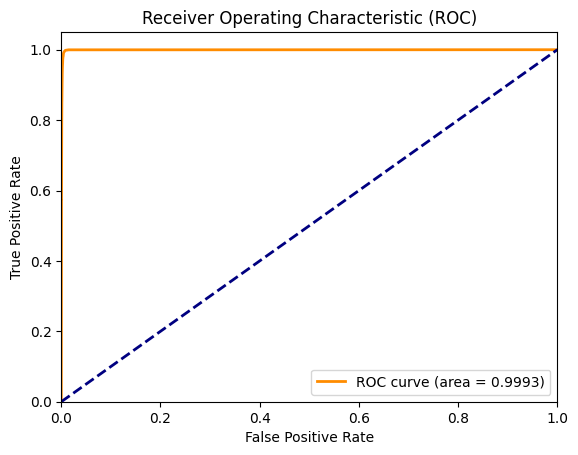

ROC AUC: 0.9993


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC and AUC Calculation
# Define evaluator for ROC and AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calculate ROC AUC
roc_auc = binary_evaluator.evaluate(final_testing_data_predictions)

# Collect predictions and labels for ROC curve
predictions_pd = final_testing_data_predictions.select("label", "rawPrediction").toPandas()

# Convert rawPrediction to probabilities for ROC
predictions_pd['probability'] = predictions_pd['rawPrediction'].apply(lambda x: x[1])  # Assuming binary classification and '1' is the positive class

# Compute ROC curve
fpr, tpr, _ = roc_curve(predictions_pd['label'], predictions_pd['probability'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")

# **5. Results Visualization**

#### Plots of all 6 models

In [ ]:
# Defining the model results
data = {'Model': [             'LR',    'DCT',   'RF',    'GBT',   'MLP', 'LinearSVC'],
    'Accuracy':               [99.97,   96.16,   99.40,   99.66,   93.60,   99.51],
    'F1 Score':               [99.97,   96.12,   99.40,   99.66,   93.59,   96.68],
    'Precision':              [99.97,   96.12,   99.40,   99.66,   93.59,   96.72],
    'Recall':                 [99.97,   96.16,   99.40,   99.66,   93.60,   96.68],
    'Precision (Non_Default)':[100,     93.33,   99.68,   99.34,   85.42,   98.10],
    'Recall (Non_Default)':   [99.98,   88.47,   97.51,   99.06,   84.73,    86.21],
    'Precision (Default)':    [99.96,   96.88,   99.32,   99.74,   95.82,   96.34],
    'Recall (Default)':       [100,     98.27,   99.91,   99.82,   96.04,  99.54]
}

# To Convert the dictionary to a Pandas DataFrame
df = pd.DataFrame(data)
df.head(10)

Model  Accuracy  F1 Score  Precision  Recall  Precision (Non_Default)  \
0         LR     99.97     99.97      99.97   99.97                   100.00   
1        DCT     96.16     96.12      96.12   96.16                    93.33   
2         RF     99.40     99.40      99.40   99.40                    99.68   
3        GBT     99.66     99.66      99.66   99.66                    99.34   
4        MLP     93.60     93.59      93.59   93.60                    85.42   
5  LinearSVC     99.51     96.68      96.72   96.68                    98.10   

   Recall (Non_Default)  Precision (Default)  Recall (Default)  
0                 99.98                99.96            100.00  
1                 88.47                96.88             98.27  
2                 97.51                99.32             99.91  
3                 99.06                99.74             99.82  
4                 84.73                95.82             96.04  
5                 86.21                96.34             99.54

In [ ]:
# # Defining the model results
# data = {'Model': [               'LR', 'DCT',   'RF',     'GBT',   'MLP', 'LinearSVC'],
#     'Accuracy':               [99.97,   96.16,   99.40,   99.66,   93.60,   99.51],
#     'F1 Score':               [99.97,   96.12,   99.40,   99.66,   93.59,   96.68],
#     'Precision':              [99.97,   96.12,   99.40,   99.66,   93.59,   96.72],
#     'Recall':                 [99.97,   96.16,   99.40,   99.66,   93.60,   96.68],
#     'Precision (Non_Default)':[100,     93.33,   99.68,   99.34,   85.42,   98.10],
#     'Recall (Non_Default)':   [99.98,   88.47,   97.51,   99.06,   84.73,    86.21],
#     'Precision (Default)':    [99.96,   96.88,   99.32,   99.74,   95.82,   96.34],
#     'Recall (Default)':       [100,     98.27,   99.91,   99.82,   96.04,  99.54]
# }

# # To Convert the dictionary to a Pandas DataFrame
# df = pd.DataFrame(data)

# show Spark DataFrame
df_spark = spark.createDataFrame(df)
df_spark.show(truncate=False)

+---------+--------+--------+---------+------+-----------------------+--------------------+-------------------+----------------+
|Model    |Accuracy|F1 Score|Precision|Recall|Precision (Non_Default)|Recall (Non_Default)|Precision (Default)|Recall (Default)|
+---------+--------+--------+---------+------+-----------------------+--------------------+-------------------+----------------+
|LR       |99.97   |99.97   |99.97    |99.97 |100.0                  |99.98               |99.96              |100.0           |
|DCT      |96.16   |96.12   |96.12    |96.16 |93.33                  |88.47               |96.88              |98.27           |
|RF       |99.4    |99.4    |99.4     |99.4  |99.68                  |97.51               |99.32              |99.91           |
|GBT      |99.66   |99.66   |99.66    |99.66 |99.34                  |99.06               |99.74              |99.82           |
|MLP      |93.6    |93.59   |93.59    |93.6  |85.42                  |84.73               |95.82 

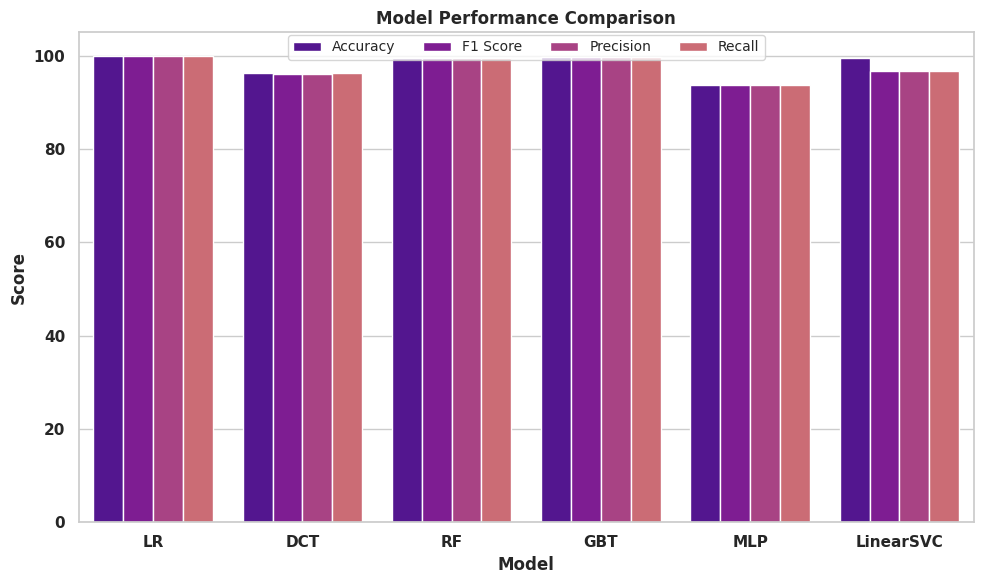

In [ ]:
# Set the style of seaborn
sns.set(style="whitegrid", palette='plasma')

# Convert Spark DataFrame to Pandas DataFrame for visualization
df = df_spark.toPandas()

# Melt the DataFrame for easier plotting with seaborn
df_melted = df.melt(id_vars='Model', value_vars=['Accuracy', 'F1 Score', 'Precision', 'Recall'],
                    var_name='Metric', value_name='Score')

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted)

# Set labels and title (bolded)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Model Performance Comparison', fontweight='bold')

# Bold x and y ticks
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Move legend to overlap bars
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.009), ncol=4, fontsize = 10)

# Display the plot
plt.tight_layout()
plt.show()

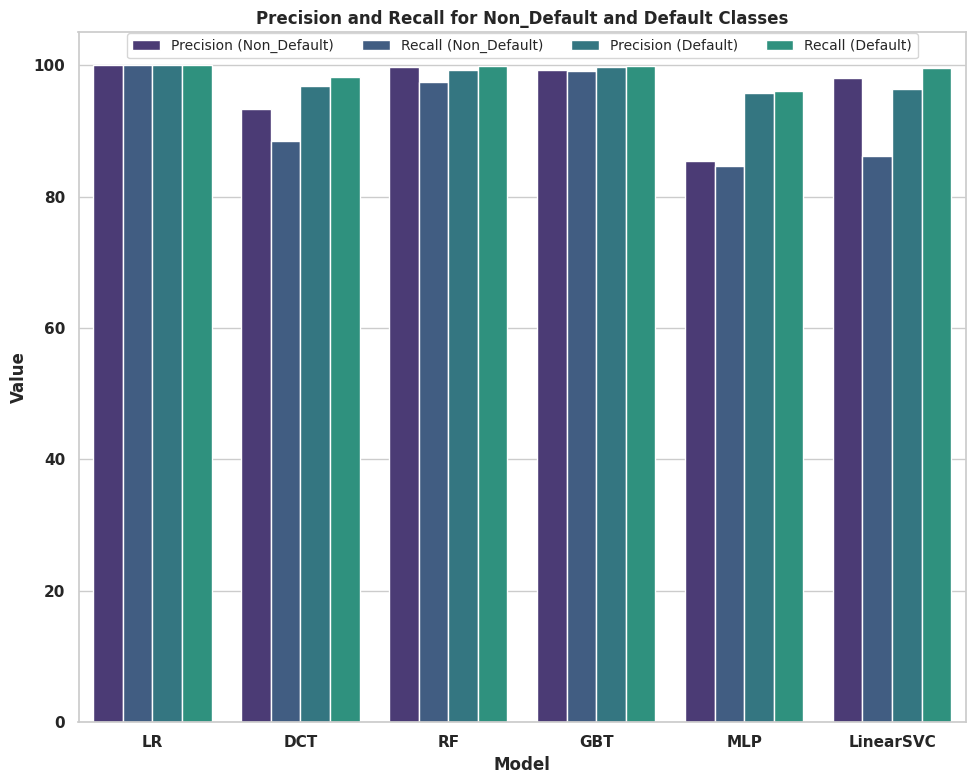

In [ ]:
sns.set(style="whitegrid", palette='viridis')
# 'inferno'
df_precision_recall = df.melt(id_vars='Model', value_vars=['Precision (Non_Default)', 'Recall (Non_Default)',
                                                         'Precision (Default)', 'Recall (Default)'],
                             var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 8))
ax2 = sns.barplot(x='Model', y='Value', hue='Metric', data=df_precision_recall)

# Set labels and title (bolded)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title('Precision and Recall for Non_Default and Default Classes', fontweight='bold')

# Bold x and y ticks
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Move legend to overlap bars
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.009), ncol=4, fontsize = 10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

#### Confusion matrics for GBT
To assess how well GBT model generalizes unseen data by evaluating model on testing data. Also to get a sense of how the model performs in a real-world scenario where it encounters new examples.

The testing set contains 273448 records and 91 features.

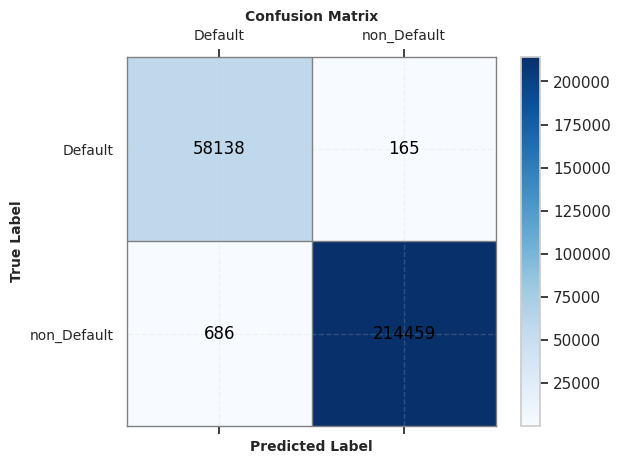

In [ ]:
# Confusion Matrix Calculation for validation test

prediction_and_labels = final_testing_data_predictions.select(["label", "finalPrediction"]) \
    .withColumn('finalPrediction', F.col('finalPrediction').cast(FloatType()))

# Convert DataFrame to RDD and compute confusion matrix
rdd = prediction_and_labels.rdd.map(lambda row: (float(row['label']), float(row['finalPrediction'])))
metrics = MulticlassMetrics(rdd)
cm_values = metrics.confusionMatrix().toArray()

# Define your labels
predicted_labels = ['Default', 'non_Default']

# Plot the confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm_values, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Add labels and title
plt.xlabel('Predicted Label', fontsize=10, fontweight='bold')
plt.ylabel('True Label', fontsize=10, fontweight='bold')
#plt.title('Confusion Matrix', fontsize=10, fontweight='bold')

# Annotate confusion matrix values
for i in range(cm_values.shape[0]):
    for j in range(cm_values.shape[1]):
        plt.text(j, i, f'{cm_values[i, j]:.0f}', ha='center', va='center', color='black')

# Customize grid and spines
plt.grid(True, linestyle='--', alpha=0.2)
axes = plt.gca()
for _, spine in axes.spines.items():
    spine.set_color('gray')
    spine.set_linewidth(1)

# Add boundaries between blocks
for i in range(len(predicted_labels) - 1):
    plt.axhline(y=i + 0.5, color='gray', linewidth=1)
    plt.axvline(x=i + 0.5, color='gray', linewidth=1)

# Set tick labels
ax.set_xticks(range(len(predicted_labels)))
ax.set_yticks(range(len(predicted_labels)))
ax.set_xticklabels(predicted_labels, fontsize=10)
ax.set_yticklabels(predicted_labels, fontsize=10)

plt.show()

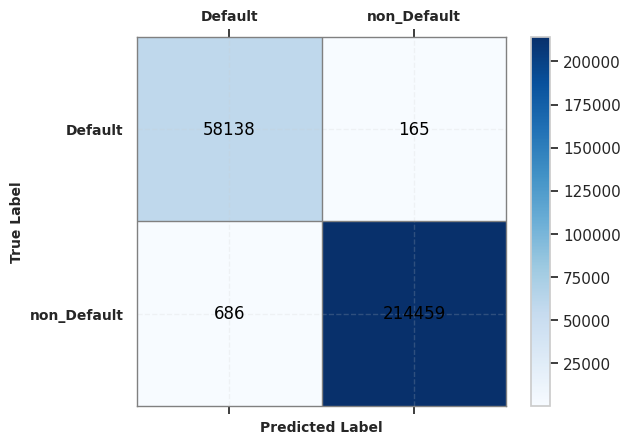

In [ ]:
# Confusion Matrix Calculation for validation test

prediction_and_labels = final_testing_data_predictions.select(["label", "finalPrediction"]) \
    .withColumn('finalPrediction', F.col('finalPrediction').cast(FloatType()))

# Convert DataFrame to RDD and compute confusion matrix
rdd = prediction_and_labels.rdd.map(lambda row: (float(row['label']), float(row['finalPrediction'])))
metrics = MulticlassMetrics(rdd)
cm_values = metrics.confusionMatrix().toArray()

# Define your labels
predicted_labels = ['Default', 'non_Default']

# Plot the confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm_values, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Add labels and title
plt.xlabel('Predicted Label', fontsize=10, fontweight='bold')
plt.ylabel('True Label', fontsize=10, fontweight='bold')
#plt.title('Confusion Matrix', fontsize=10, fontweight='bold')

# Annotate confusion matrix values
for i in range(cm_values.shape[0]):
    for j in range(cm_values.shape[1]):
        plt.text(j, i, f'{cm_values[i, j]:.0f}', ha='center', va='center', color='black')

# Customize grid and spines
plt.grid(True, linestyle='--', alpha=0.2)
axes = plt.gca()
for _, spine in axes.spines.items():
    spine.set_color('gray')
    spine.set_linewidth(1)

# Add boundaries between blocks
for i in range(len(predicted_labels) - 1):
    plt.axhline(y=i + 0.5, color='gray', linewidth=1)
    plt.axvline(x=i + 0.5, color='gray', linewidth=1)

# Set tick labels
ax.set_xticks(range(len(predicted_labels)))
ax.set_yticks(range(len(predicted_labels)))
ax.set_xticklabels(predicted_labels, fontsize=10, fontweight='bold')  # Make x tick labels bold
ax.set_yticklabels(predicted_labels, fontsize=10, fontweight='bold')  # Make y tick labels bold

plt.show()


**Models Performance Analysis**

